<a href="https://colab.research.google.com/github/bhanu-50/Business-Case-Study-TARGET-SQL/blob/main/BSD_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

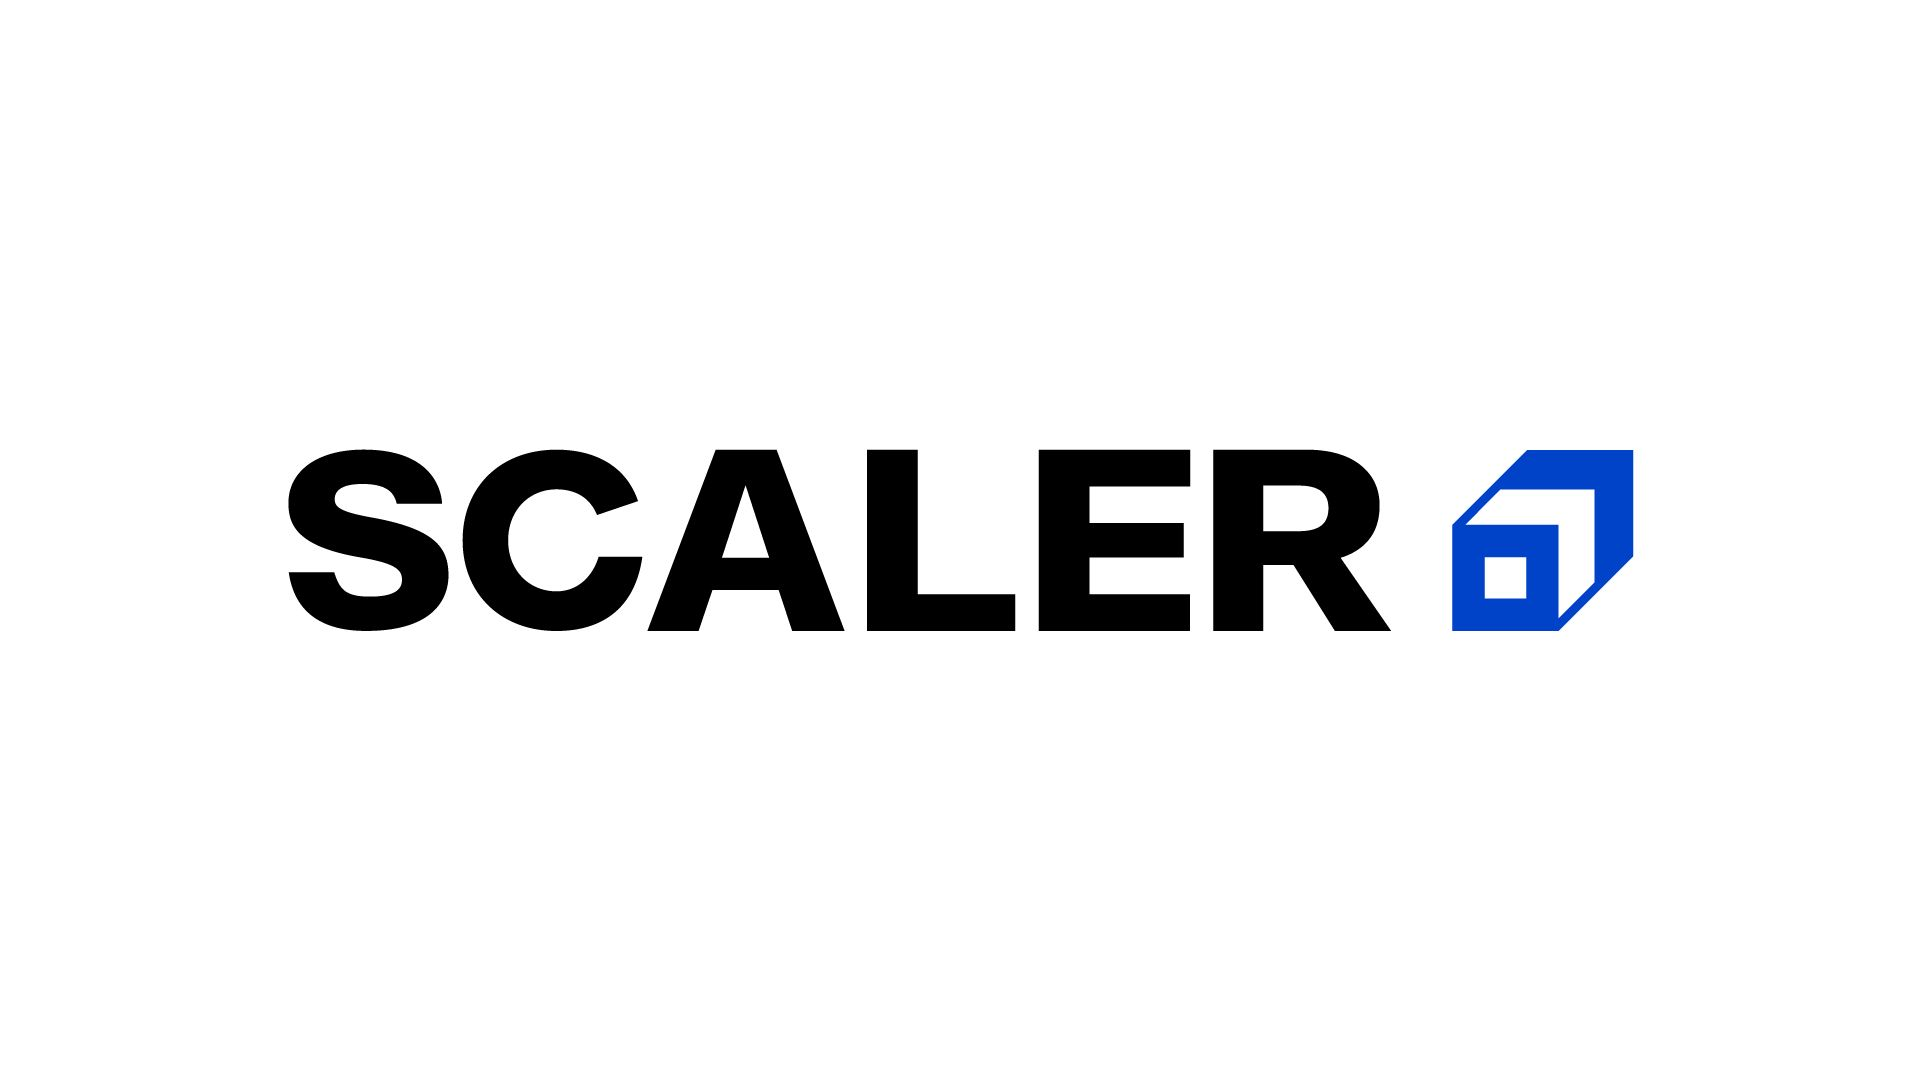

#Introduction

Scaler is an online tech-versity offering intensive computer science & Data Science courses through live classes delivered by tech leaders and subject matter experts. The meticulously structured program enhances the skills of software professionals by offering a modern curriculum with exposure to the latest technologies. It is a product by InterviewBit.

Working as a data scientist with the analytics vertical of Scaler, focused on profiling the best companies and job positions to work for from the Scaler database. Provided with the information for a segment of learners and tasked to cluster them on the basis of their job profile, company, and other features. Ideally, these clusters should have similar characteristics.

#Know your Data

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
!gdown https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/002/856/original/scaler_clustering.csv

Downloading...
From: https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/002/856/original/scaler_clustering.csv
To: /content/scaler_clustering.csv
100% 24.7M/24.7M [00:00<00:00, 170MB/s]


In [9]:
df=pd.read_csv('/content/scaler_clustering.csv')

In [10]:
df

,Unnamed: 0,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year
0,0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016.0,1100000,Other,2020.0
1,1,qtrxvzwt xzegwgbb rxbxnta,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,2018.0,449999,FullStack Engineer,2019.0
2,2,ojzwnvwnxw vx,4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...,2015.0,2000000,Backend Engineer,2020.0
3,3,ngpgutaxv,effdede7a2e7c2af664c8a31d9346385016128d66bbc58...,2017.0,700000,Backend Engineer,2019.0
4,4,qxen sqghu,6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...,2017.0,1400000,FullStack Engineer,2019.0
...,...,...,...,...,...,...,...
205838,206918,vuurt xzw,70027b728c8ee901fe979533ed94ffda97be08fc23f33b...,2008.0,220000,NaN,2019.0
205839,206919,husqvawgb,7f7292ffad724ebbe9ca860f515245368d714c84705b42...,2017.0,500000,NaN,2020.0
205840,206920,vwwgrxnt,cb25cc7304e9a24facda7f5567c7922ffc48e3d5d6018c...,2021.0,700000,NaN,2021.0
205841,206921,zgn vuurxwvmrt,fb46a1a2752f5f652ce634f6178d0578ef6995ee59f6c8...,2019.0,5100000,NaN,2019.0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205843 entries, 0 to 205842
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        205843 non-null  int64  
 1   company_hash      205799 non-null  object 
 2   email_hash        205843 non-null  object 
 3   orgyear           205757 non-null  float64
 4   ctc               205843 non-null  int64  
 5   job_position      153279 non-null  object 
 6   ctc_updated_year  205843 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 11.0+ MB


**Data Dictionary:**

1. ‘Unnamed 0’ - Index of the dataset
2. Email_hash - Anonymised Personal Identifiable Information (PII)
3. Company_hash - This represents an anonymized identifier for the company, which is the current employer of the learner.
4. orgyear - Employment start date
5. CTC - Current CTC
6. Job_position - Job profile in the company
7. CTC_updated_year - Year in which CTC got updated (Yearly increments, Promotions)

In [12]:
df.describe(exclude=['float64','int64']).T

,count,unique,top,freq
company_hash,205799,37299,nvnv wgzohrnvzwj otqcxwto,8337
email_hash,205843,153443,bbace3cc586400bbc65765bc6a16b77d8913836cfc98b7...,10
job_position,153279,1016,Backend Engineer,43554


**Observations:**

- There are 205843 rows and 7 columns
- Null Values observed in 3 columns
- Backend Engineer is the most frequent Job Position in the dataset.
- Further analysis can be better performed post EDA, handling null, duplicates and outliers

#Data Preprocessing

- Data Cleaning
- Checking Duplicates and Treatment
- Checking Outliers and Treatment using Capping
- Checking Null Values and Treatment using KNN imputation for Numerical attributes
- Remove Special characters using Regex
- Feature Engineering

In [13]:
df1=df.copy()

**Regex for Cleaning Company Names**

In [14]:
import re

In [15]:
# Function to clean special characters
def clean_string(s):
    if not isinstance(s, str):
        s = str(s)
    return re.sub('[^A-Za-z0-9 ]+', '', s)

# Apply the function to the 'company_hash' column
df1['company_hash'] = df1['company_hash'].apply(clean_string)


**Check Duplicates**

In [16]:
df1.duplicated().any()

np.False_

- No Duplicate rows observed overall in the dataset

**Check Duplicates based on Email_hash and remove them to ensure uniqueness of each learner's data**

In [17]:
combined_duplicates = df[df.duplicated(subset=['email_hash'], keep=False)]
print(f"Number of duplicate rows based on 'email_hash': {combined_duplicates.shape[0]}")

# Display the duplicate rows
print(combined_duplicates)

Number of duplicate rows based on 'email_hash': 93616
        Unnamed: 0                         company_hash  \
0                0                       atrgxnnt xzaxv   
1                1            qtrxvzwt xzegwgbb rxbxnta   
2                2                        ojzwnvwnxw vx   
4                4                           qxen sqghu   
5                5  yvuuxrj hzbvqqxta bvqptnxzs ucn rna   
...            ...                                  ...   
205827      206907                             btaxvztn   
205830      206910                       zgn vuurxwvmrt   
205831      206911             tcxct ogenfvqt vzvrjnxwo   
205837      206917                       zgn vuurxwvmrt   
205838      206918                            vuurt xzw   

                                               email_hash  orgyear      ctc  \
0       6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...   2016.0  1100000   
1       b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...   2018.0   449999   


In [18]:
df1= df1.drop_duplicates(subset=['email_hash'], keep='last')

- Removed Duplicates based on Email_hash
- Multiple individuals can be associated with the same company, so using company_hash alone may not ensure the uniqueness of learners
- Could have considered both Email and Company for duplicate. This would have ensured that we don't remove valid records where the same individual is associated with multiple companies. But with limited information currently going ahead with removing duplicates based on Email_hash to ensure uniqueness of each learner's data

**Check Null Values**

In [19]:
df1.isna().sum()

,0
Unnamed: 0,0
company_hash,0
email_hash,0
orgyear,79
ctc,0
job_position,34191
ctc_updated_year,0


- job_position has high number of null values
- company_hash and orgyear have got few null values
- Will treat null values upon further analysis

**Check Unique Values for Each Feature and Convert Data type if needed**

In [20]:
# Non-numeric columns
obj_cols = df1.select_dtypes(include='object').columns
obj_cols

Index(['company_hash', 'email_hash', 'job_position'], dtype='object')

In [21]:
for _ in obj_cols:
    print()
    print(f'Total Unique Values in {_} column are :- {df1[_].nunique()}')
    print(f'Value counts in {_} column are :-\n {df1[_].value_counts()}')
    print()
    print('-'*120)


Total Unique Values in company_hash column are :- 36366
Value counts in company_hash column are :-
 company_hash
nvnv wgzohrnvzwj otqcxwto                   5336
xzegojo                                     3526
vbvkgz                                      2440
wgszxkvzn                                   2199
zgn vuurxwvmrt vwwghzn                      2192
                                            ... 
nqvzoftm srgmvr xzwgqugqvnxgz                  1
uqguqgeowgb                                    1
txrjoxo                                        1
vbzo                                           1
ftvnytq qxop bvzvstbtzn otqcxwto ucn rna       1
Name: count, Length: 36366, dtype: int64

------------------------------------------------------------------------------------------------------------------------

Total Unique Values in email_hash column are :- 153443
Value counts in email_hash column are :-
 email_hash
0bcfc1d05f2e8dc4147743a1313aa70a119b41b30d4a1f7e738a6a87d3712c31    1
effde

- Since company and email are hashed so not much information can be inferred. However, we can conveniently identify contribution of each element to the Feature
- Since email_hash is unique for every learner so it is correctly showing frequency as 1 for each email
- Backend Engineer is the most frequent with 33154 value counts followed by FullStack Engineer and Other

In [22]:
# Numeric columns
num_cols = df1.select_dtypes(include='number').columns
num_cols

Index(['Unnamed: 0', 'orgyear', 'ctc', 'ctc_updated_year'], dtype='object')

In [23]:
for _ in num_cols:
    print()
    print(f'Total Unique Values in {_} column are :- {df1[_].nunique()}')
    print(f'Value counts in {_} column are :-\n {df1[_].value_counts(normalize=True)}')
    print()
    print('-'*120)


Total Unique Values in Unnamed: 0 column are :- 153443
Value counts in Unnamed: 0 column are :-
 Unnamed: 0
206922    0.000007
3         0.000007
7         0.000007
206906    0.000007
206905    0.000007
            ...   
21        0.000007
17        0.000007
16        0.000007
14        0.000007
13        0.000007
Name: proportion, Length: 153443, dtype: float64

------------------------------------------------------------------------------------------------------------------------

Total Unique Values in orgyear column are :- 76
Value counts in orgyear column are :-
 orgyear
2016.0    0.112993
2018.0    0.109661
2017.0    0.107985
2015.0    0.104249
2019.0    0.098022
            ...   
2204.0    0.000007
201.0     0.000007
1900.0    0.000007
38.0      0.000007
200.0     0.000007
Name: proportion, Length: 76, dtype: float64

------------------------------------------------------------------------------------------------------------------------

Total Unique Values in ctc column are 

- Unnamed: 0 do not provide any useful information, will drop this column
- ctc_updated_year to be converted to datetime datatype for further analysis
- orgyear is the starting year of employment. We could identify many invalid entries like 200,208,2107 ..which are not valid years. This column will undergo treatment
- Maximum Learners have got CTC of 6 Lac followed by 10 Lac and 4 Lac

**Removing column 'Unnamed: 0' as it does not have any useful information**

In [24]:
df1 = df1.drop(columns=['Unnamed: 0'])

**Convert Required Columns to Datetime datatype**

In [25]:
df1['ctc_updated_year'] = pd.to_datetime(df1['ctc_updated_year'], format='%Y')
df1['ctc_updated_year'] = df1['ctc_updated_year'].dt.year

**Treatment of column 'orgyear'**

orgyear is the starting year of employment. We could identify many invalid entries like 200,208,2107 ..which are not valid years.  

In [26]:
# Define the range of valid years (e.g., 1900 to 2023)
valid_years = range(1900, 2024)

# Replace invalid years with NaN
df1['orgyear'] = df1['orgyear'].apply(lambda x: x if x in valid_years else np.nan)

# Convert valid years to datetime
df1['orgyear'] = pd.to_datetime(df1['orgyear'].dropna().astype(int), format='%Y')
df1['orgyear'] = df1['orgyear'].dt.year
df1['orgyear']=df1['orgyear'].astype('Int64')


**Treatment of Null Values**

In [27]:
df1.isna().sum()

,0
company_hash,0
email_hash,0
orgyear,186
ctc,0
job_position,34191
ctc_updated_year,0


In [28]:
from sklearn.impute import KNNImputer

**KNN Imputation for Numerical Column**

In [29]:
# Impute missing values in Job Position column with 'Other'
df1['job_position'].fillna('unknown', inplace=True)

# Impute missing values in numerical columns using KNN
knn_imputer = KNNImputer(n_neighbors=3)

# Select only numerical columns for KNN imputation
numerical_cols = ['orgyear']

# Fit and transform the KNN imputer on the numerical columns
df1[numerical_cols] = knn_imputer.fit_transform(df1[numerical_cols])


/tmp/ipython-input-2113973626.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['job_position'].fillna('unknown', inplace=True)


In [30]:
# Convert orgyear back to int
df1['orgyear'] = df1['orgyear'].astype(int)

- For job_position, filled missing values with the string 'unknown'. This ensures that the analysis considers these entries as a separate category rather than skewing the distribution of existing categories. This approach maintains the integrity of the categorical data while addressing missing values in a straightforward and non-biased manner.
- Applied KNN imputation to fill missing values in the orgyear column. This leverages the relationships between existing data points to predict the missing values.


**Feature Engineering**

Creating new feature 'YOE' Years of Experience

In [31]:
from datetime import datetime

In [32]:
# Get the current year
current_year = datetime.now().year

# Create the YOE column by subtracting orgyear from current_year
df1['YOE'] = current_year - df1['orgyear']

In [33]:
df1.head()

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,YOE
3,ngpgutaxv,effdede7a2e7c2af664c8a31d9346385016128d66bbc58...,2017,700000,Backend Engineer,2019,8
7,vwwtznhqt ntwyzgrgsj,756d35a7f6bb8ffeaffc8fcca9ddbb78e7450fa0de2be0...,2019,400000,Backend Engineer,2019,6
9,xrbhd,b2dc928f4c22a9860b4a427efb8ab761e1ce0015fba1a5...,2019,360000,unknown,2019,6
13,wgszxkvzn,134cc4a76a119493d523f1855a3b7106f64287455d5cd4...,2016,440000,Data Analyst,2020,9
14,xznhxn,ebcaf397ef5084e05889a6e9a0c3f96a5c8fb0b16749ce...,2016,440000,Backend Engineer,2019,9


**Checking Outliers**

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
df2=df1.copy()

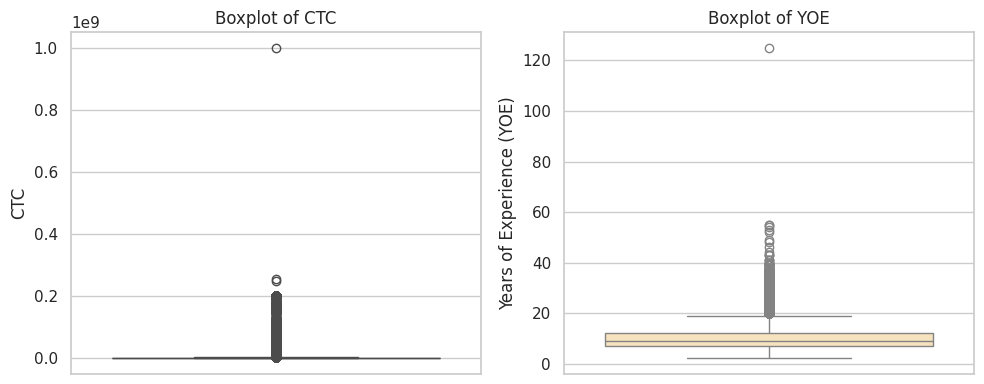

In [36]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Create a figure with two subplots for CTC and YOE
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Boxplot for CTC
sns.boxplot(data=df2, y='ctc', ax=ax[0])
ax[0].set_title('Boxplot of CTC')
ax[0].set_ylabel('CTC')

# Boxplot for YOE
sns.boxplot(data=df2, y='YOE', ax=ax[1],color='moccasin')
ax[1].set_title('Boxplot of YOE')
ax[1].set_ylabel('Years of Experience (YOE)')

# Show the plots
plt.tight_layout()
plt.show()

- We can clearly observe outliers in ctc and YOE
- Outliers can significantly impact the performance and results of clustering algorithms like K-means and hierarchical clustering

**Treatment of Outliers**

Used Capping method to treat outliers. This approach reduces the impact of extreme outliers without completely removing data points.

In [37]:
# Calculate upper bound for ctc using 99th percentile
ctc_upper_bound = df2['ctc'].quantile(0.99)

# Apply clipping to ctc column
df2['ctc_capped'] = np.clip(df2['ctc'], df2['ctc'].min(), ctc_upper_bound)

In [38]:
# Calculate upper bound for YOE using 99th percentile
yoe_upper_bound = df2['YOE'].quantile(0.99)

# Apply clipping to YOE column
df2['YOE_capped'] = np.clip(df2['YOE'], df2['YOE'].min(), yoe_upper_bound)

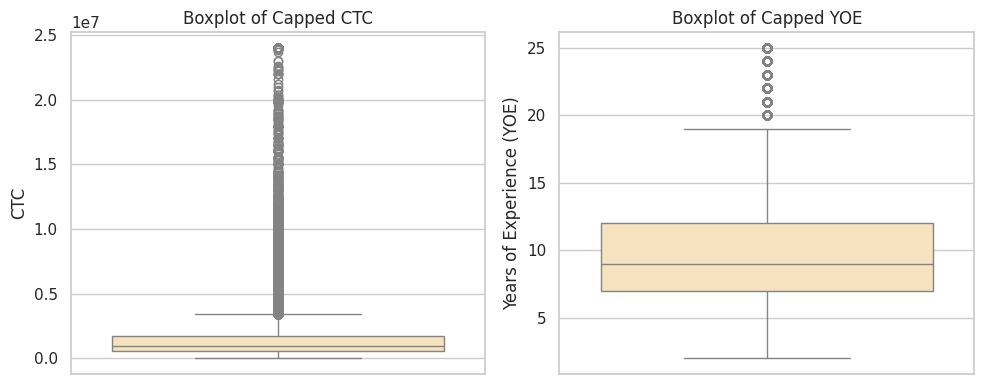

In [39]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Create a figure with two subplots for CTC and YOE
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Boxplot for CTC post Capping
sns.boxplot(data=df2, y='ctc_capped', ax=ax[0],color='moccasin')
ax[0].set_title('Boxplot of Capped CTC')
ax[0].set_ylabel('CTC')

# Boxplot for YOE post Capping
sns.boxplot(data=df2, y='YOE_capped', ax=ax[1],color='moccasin')
ax[1].set_title('Boxplot of Capped YOE')
ax[1].set_ylabel('Years of Experience (YOE)')

# Show the plots
plt.tight_layout()
plt.show()

- We can observe that extreme outliers have been treated with capping method.
- Setting the upper percentile to 99% is a way to include most of the data points while excluding the extreme 1% of outliers that are far from the rest of the data.
- This approach ensured that the majority of data remains intact, while the extreme values that could significantly impact the clustering results are capped.
- Created two new capped columns while keeping the original columns if needed to refer further

In [40]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153443 entries, 3 to 205842
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   company_hash      153443 non-null  object
 1   email_hash        153443 non-null  object
 2   orgyear           153443 non-null  int64 
 3   ctc               153443 non-null  int64 
 4   job_position      153443 non-null  object
 5   ctc_updated_year  153443 non-null  int32 
 6   YOE               153443 non-null  int64 
 7   ctc_capped        153443 non-null  int64 
 8   YOE_capped        153443 non-null  int64 
dtypes: int32(1), int64(5), object(3)
memory usage: 11.1+ MB


#Manual Clustering

- Creating Designation Flag & Insights
- Creating Class Flag & Insights
- Creating Tier Flag & Insights

In [41]:
df3=df2.copy()

Dropping original columns ctc and YOE for capped_ctc and capped_YOE
- Analysis will be more consistent and robust when performed on a dataset where extreme values have been controlled or standardized through capping.
- Capped Feature preserves the integrity of the dataset by retaining most data points while adjusting extreme values. This ensures that the analysis reflects the general trends and patterns in the data without being overly influenced by outliers.




In [42]:
# Drop original ctc and YOE columns
df3.drop(['ctc', 'YOE'], axis=1, inplace=True)

In [43]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153443 entries, 3 to 205842
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   company_hash      153443 non-null  object
 1   email_hash        153443 non-null  object
 2   orgyear           153443 non-null  int64 
 3   job_position      153443 non-null  object
 4   ctc_updated_year  153443 non-null  int32 
 5   ctc_capped        153443 non-null  int64 
 6   YOE_capped        153443 non-null  int64 
dtypes: int32(1), int64(3), object(3)
memory usage: 8.8+ MB


Creating Flags:
- Designation Flag: CTC on the basis of Company, Job Position and Years of Experience
- Class Flag:  CTC On the basis of Company and Job Position
- Tier Flag: CTC On the basis of Company

In [44]:
# Step 1: Group by company, job position, and years of experience (Designation)
grouped_summary_designation = df3.groupby(['company_hash', 'job_position', 'YOE_capped'])['ctc_capped'].agg(['mean', 'median', 'max', 'min', 'count']).reset_index()
grouped_summary_designation.rename(columns={'mean': 'mean_designation'}, inplace=True)

# Group by company and years of experience (Class)
grouped_summary_class = df3.groupby(['company_hash', 'job_position'])['ctc_capped'].agg(['mean', 'median', 'max', 'min', 'count']).reset_index()
grouped_summary_class.rename(columns={'mean': 'mean_class'}, inplace=True)

# Group by company level only (Tier)
grouped_summary_tier = df3.groupby(['company_hash'])['ctc_capped'].agg(['mean', 'median', 'max', 'min', 'count']).reset_index()
grouped_summary_tier.rename(columns={'mean': 'mean_tier'}, inplace=True)

# Step 2: Merge only the mean values with the original dataset
df3 = df3.merge(grouped_summary_designation[['company_hash', 'job_position', 'YOE_capped', 'mean_designation']], on=['company_hash', 'job_position', 'YOE_capped'])
df3 = df3.merge(grouped_summary_class[['company_hash', 'job_position', 'mean_class']], on=['company_hash', 'job_position'])
df3 = df3.merge(grouped_summary_tier[['company_hash', 'mean_tier']], on=['company_hash'])

# Step 3: Create flags for Designation, Class, and Tier based on mean values
def designation_flag(row):
    if row['ctc_capped'] > row['mean_designation']:
        return 3
    elif row['ctc_capped'] == row['mean_designation']:
        return 2
    else:
        return 1

def class_flag(row):
    if row['ctc_capped'] > row['mean_class']:
        return 3
    elif row['ctc_capped'] == row['mean_class']:
        return 2
    else:
        return 1

def tier_flag(row):
    if row['ctc_capped'] > row['mean_tier']:
        return 3
    elif row['ctc_capped'] == row['mean_tier']:
        return 2
    else:
        return 1

df3['Designation_Flag'] = df3.apply(designation_flag, axis=1)
df3['Class_Flag'] = df3.apply(class_flag, axis=1)
df3['Tier_Flag'] = df3.apply(tier_flag, axis=1)

# Step 4: Check if columns exist before attempting to drop them
columns_to_drop = ['mean_class', 'mean_designation', 'mean_tier']
df3.drop(columns=[col for col in columns_to_drop if col in df3.columns], inplace=True)

In [45]:
grouped_summary_designation.head()

,company_hash,job_position,YOE_capped,mean_designation,median,max,min,count
0,0,Other,5,100000.0,100000.0,100000,100000,1
1,0000,Other,8,300000.0,300000.0,300000,300000,1
2,01 ojztqsj,Android Engineer,9,270000.0,270000.0,270000,270000,1
3,01 ojztqsj,Frontend Engineer,14,830000.0,830000.0,830000,830000,1
4,05mz exzytvrny uqxcvnt rxbxnta,Backend Engineer,6,1100000.0,1100000.0,1100000,1100000,1


In [46]:
grouped_summary_class.head()

,company_hash,job_position,mean_class,median,max,min,count
0,0,Other,100000.0,100000.0,100000,100000,1
1,0000,Other,300000.0,300000.0,300000,300000,1
2,01 ojztqsj,Android Engineer,270000.0,270000.0,270000,270000,1
3,01 ojztqsj,Frontend Engineer,830000.0,830000.0,830000,830000,1
4,05mz exzytvrny uqxcvnt rxbxnta,Backend Engineer,1100000.0,1100000.0,1100000,1100000,1


In [47]:
grouped_summary_tier.head()

,company_hash,mean_tier,median,max,min,count
0,0,100000.0,100000.0,100000,100000,1
1,0000,300000.0,300000.0,300000,300000,1
2,01 ojztqsj,550000.0,550000.0,830000,270000,2
3,05mz exzytvrny uqxcvnt rxbxnta,1100000.0,1100000.0,1100000,1100000,1
4,1,175000.0,175000.0,250000,100000,2


In [48]:
df3.head()

,company_hash,email_hash,orgyear,job_position,ctc_updated_year,ctc_capped,YOE_capped,Designation_Flag,Class_Flag,Tier_Flag
0,ngpgutaxv,effdede7a2e7c2af664c8a31d9346385016128d66bbc58...,2017,Backend Engineer,2019,700000,8,1,1,1
1,vwwtznhqt ntwyzgrgsj,756d35a7f6bb8ffeaffc8fcca9ddbb78e7450fa0de2be0...,2019,Backend Engineer,2019,400000,6,1,1,1
2,xrbhd,b2dc928f4c22a9860b4a427efb8ab761e1ce0015fba1a5...,2019,unknown,2019,360000,6,2,2,2
3,wgszxkvzn,134cc4a76a119493d523f1855a3b7106f64287455d5cd4...,2016,Data Analyst,2020,440000,9,1,1,1
4,xznhxn,ebcaf397ef5084e05889a6e9a0c3f96a5c8fb0b16749ce...,2016,Backend Engineer,2019,440000,9,1,1,1


Three new Features / Flags have been created

*We can derive many insights from each of these flags, following are few explorations*

**Designation Flag- Exploration**

Top 10 Employees with Designation Flag 1 (Earning More Than Most of Their Peers with Same Job Position and Experience)

In [49]:
top_10_designation1 = df3[df3['Designation_Flag'] == 1].nlargest(10, 'ctc_capped')
top_10_designation1

,company_hash,email_hash,orgyear,job_position,ctc_updated_year,ctc_capped,YOE_capped,Designation_Flag,Class_Flag,Tier_Flag
5984,ofxssj,e6b830e44ae282c86a370685a6e3bb3aa82ec995eec5db...,2014,Other,2020,11200000,11,1,3,3
141146,vbvkgz ftm otqcxwto,0932dc8d855953b2ac63c8046c9fb33f7f554174b6c2fe...,2013,Backend Engineer,2019,11200000,12,1,3,3
124808,sqvm,ed3b3231ac4758173e68bcde8eac3842497e153d9d1832...,2015,Engineering Leadership,2019,9200000,10,1,3,3
141694,hmtq,9885423385b89dd905f1df74a1d6e71906ccccd915c7e4...,2013,Engineering Leadership,2020,8500000,12,1,3,3
71127,xzntr wgqugqvnxgz,9aa54ea5c7e0b2567cc43718bd6516f3cfefb5622b6e2b...,2015,Other,2021,8400000,10,1,3,3
51532,fvrbvqn rvmo,9adf861294aa69336409395a5474ce6f9ffbfd38594ed4...,2010,Backend Architect,2019,8100000,15,1,3,3
149217,vba,f9530fc2d3629fc9a04c7e4e2ea6b8ddbe03eb3a97caff...,2003,Engineering Leadership,2020,8100000,22,1,1,3
2890,eqttwyvqst,28dc7d414a336ebfecf691f1db3b9cdc95b58ffede1107...,2005,Engineering Leadership,2020,7300000,20,1,3,3
40534,gnytq,4f4f4bac863dc79205345fd614a4e4cd4c99718533c60d...,2017,Data Analyst,2019,7300000,8,1,3,3
115313,sggsrt,97f2289a59953b4e94f8d2436f6edf621b9a359d919bbc...,2019,FullStack Engineer,2020,7300000,6,1,3,3


Bottom 10 Employees with Designation Flag 3 (Earning Less Than Most of Their Peers with Same Job Position and Experience)

In [50]:
bottom_10_designation3 = df3[df3['Designation_Flag'] == 3].nsmallest(10, 'ctc_capped')
bottom_10_designation3

,company_hash,email_hash,orgyear,job_position,ctc_updated_year,ctc_capped,YOE_capped,Designation_Flag,Class_Flag,Tier_Flag
73575,xzntqcxtfmxn,23ad96d6b6f1ecf554a52f6e9b61677c7d73d8a409a143...,2013,unknown,2018,14,12,3,1,1
43232,xz rgwg,66573ebeb4fcfc496d2af1548a18a62ec3a48dae59d1cc...,2016,Backend Engineer,2016,16000,9,3,3,3
59186,xmtd,792ac1d3daa5bc5fef39e3d61e0722cce004a0b81966b1...,2016,FullStack Engineer,2021,27000,9,3,3,3
47719,wgbgag,87f95061ed13da965818fded3d19249bc6d88de3b73ff2...,2014,Backend Engineer,2017,36000,11,3,3,1
94108,kvrgqv sqghu,0b1eeb6d24629a06d29fcd410c02d0f1f2577a0a050c54...,2017,Backend Engineer,2020,40000,8,3,3,3
65176,ogwxn szqvrt,38e8416bc59782b9fb60b144657130662ec8dab8094a41...,2018,Data Scientist,2021,55000,7,3,1,1
124414,cxkqn,718ad268d9c671de079ff1c55f93e91a2d06928243ad29...,2011,Backend Engineer,2020,55000,14,3,3,3
112825,zvnxgzvr wgrrtst ge xqtrvza,fb10b6e7b4fcc82e96f5a591146046c0988c23cccb8269...,2019,Other,2019,60000,6,3,3,3
146490,wtqz,217504679c19c4738eb44eacb651c80432d3a3801f62a5...,2014,FullStack Engineer,2019,65000,11,3,3,1
56743,jvzatd,2f31b0f7d87048f22a9a6eb33526325d0b3f470185652b...,2019,Backend Engineer,2020,70000,6,3,1,1


Top 10 Employees in Each Company with Designation Flag 1

In [51]:
top_10_each_company_designation1 = df3[df3['Designation_Flag'] == 1].groupby('company_hash').apply(lambda x: x.nlargest(10, 'ctc_capped')).reset_index(drop=True)
top_10_each_company_designation1

/tmp/ipython-input-633303111.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_10_each_company_designation1 = df3[df3['Designation_Flag'] == 1].groupby('company_hash').apply(lambda x: x.nlargest(10, 'ctc_capped')).reset_index(drop=True)


,company_hash,email_hash,orgyear,job_position,ctc_updated_year,ctc_capped,YOE_capped,Designation_Flag,Class_Flag,Tier_Flag
0,1bs,9c02076a74a2b8a64a6e003fa0a2e4115fc717dacb3585...,2016,Backend Engineer,2020,2320000,9,1,3,3
1,1bs,38dfe791fc911da418b67aa989a6aa7f00b8c680c6d4e1...,2015,Backend Engineer,2019,2000000,10,1,3,3
2,1bs,c97fd1612080086b898e440529c86325ae8ddf2e9a0b60...,2015,Backend Engineer,2019,1800000,10,1,3,3
3,1bs,7c6f711001cae257c36a621abb0b6ffa249b3d92240ee4...,2014,unknown,2017,1500000,11,1,1,1
4,1bs,bde68bd40e5bf94d4af39e89c6fe8af4b0926e4286de55...,2017,unknown,2021,1300000,8,1,1,1
...,...,...,...,...,...,...,...,...,...,...
8457,zxztrtvuo,b5628c03989a151f60c89e726351817c3a62078e7c70de...,2016,FullStack Engineer,2019,575000,9,1,1,1
8458,zxztrtvuo,41367fd92cd85ecfa2e2ce76f4ff94cde287b95df93871...,2018,Frontend Engineer,2019,570000,7,1,1,1
8459,zxztrtvuo,f09524b67053af24c9e446c0dd4d861cf053470ceaf0c9...,2020,unknown,2020,550000,5,1,1,1
8460,zxztrtvuo,73ed57fdb578ccb723d176b1624bb29b0e840e89ab4230...,2019,Backend Engineer,2021,520000,6,1,1,1


**Class Flag- Exploration**

Top 10 employees of FullStack Engineer in each company earning more than their peers - Class 1

In [52]:
top_10_class1_fs = df3[(df3['job_position'] == 'FullStack Engineer') & (df3['Class_Flag'] == 1)]
top_10_class1_fs = top_10_class1_fs.groupby('company_hash').apply(lambda x: x.nlargest(10, 'ctc_capped')).reset_index(drop=True)

/tmp/ipython-input-4177404748.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_10_class1_fs = top_10_class1_fs.groupby('company_hash').apply(lambda x: x.nlargest(10, 'ctc_capped')).reset_index(drop=True)


In [53]:
top_10_class1_fs

,company_hash,email_hash,orgyear,job_position,ctc_updated_year,ctc_capped,YOE_capped,Designation_Flag,Class_Flag,Tier_Flag
0,1bs,4ccdf10738e25d4f5ac6b85572ca7454453e17c5b1091b...,2019,FullStack Engineer,2021,1350000,6,2,1,1
1,1bs,55824c4e7df3af153fdfe867c15a599a6e86432c33f7c6...,2018,FullStack Engineer,2019,1300000,7,2,1,1
2,1bs ntwyzgrgsxto ucn rna,4c1e4fa4b2a7ef873e1f2b7104790a2b85aa51cae54585...,2016,FullStack Engineer,2019,900000,9,2,1,1
3,1bs ntwyzgrgsxto ucn rna,31d074dc51e6fabd2a235c23a3d9ae0e3702cf78f270e9...,2018,FullStack Engineer,2020,800000,7,2,1,1
4,2017,03b2ac96f3c199bcf9a5b4176d63750cd522cc315537a2...,2015,FullStack Engineer,2019,380000,10,2,1,1
...,...,...,...,...,...,...,...,...,...,...
4004,zxzlvwvqn,e2377e7ee0d53d2e3a45b9687fdc9c08b136b1dc470806...,2017,FullStack Engineer,2020,2300000,8,3,1,3
4005,zxzlvwvqn,e38914706e3522ee5773627abe091edd8c6596b8519a80...,2017,FullStack Engineer,2019,900000,8,1,1,1
4006,zxztrtvuo,af742fa47c46fa167ddfaf9c22a12a31cff23717582daa...,2018,FullStack Engineer,2020,710000,7,2,1,1
4007,zxztrtvuo,b5628c03989a151f60c89e726351817c3a62078e7c70de...,2016,FullStack Engineer,2019,575000,9,1,1,1


Bottom 10 Employees of FullStack Engineer in Each Company Earning Less Than Their Peers - Class 3

In [54]:
bottom_10_class3_fs = df3[(df3['job_position'] == 'FullStack Engineer') & (df3['Class_Flag'] == 3)]
bottom_10_class3_fs = bottom_10_class3_fs.groupby('company_hash').apply(lambda x: x.nsmallest(10, 'ctc_capped')).reset_index(drop=True)

/tmp/ipython-input-2299531944.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bottom_10_class3_fs = bottom_10_class3_fs.groupby('company_hash').apply(lambda x: x.nsmallest(10, 'ctc_capped')).reset_index(drop=True)


In [55]:
bottom_10_class3_fs

,company_hash,email_hash,orgyear,job_position,ctc_updated_year,ctc_capped,YOE_capped,Designation_Flag,Class_Flag,Tier_Flag
0,1bs,a58fadbfbc00c007dfe6e5d5891f2dda013eb5cc66552a...,2014,FullStack Engineer,2019,1600000,11,2,3,3
1,1bs ntwyzgrgsxto ucn rna,70ba4ee689ae53a942d5a9dffe2ceae1d776ca5736e69e...,2015,FullStack Engineer,2020,2800000,10,2,3,3
2,2017,59e55425c5c878bc984e046f7664ca70e4d0df93bb21f0...,2016,FullStack Engineer,2018,500000,9,2,3,3
3,247 xrvm,e959c3dae7a03c57d6bf03d299e623be9f7e736184788b...,2008,FullStack Engineer,2018,2500000,17,2,3,1
4,247vx,f8b27f9ca749c05db8ed076d13534413b63f2a2185234d...,2014,FullStack Engineer,2020,1500000,11,1,3,1
...,...,...,...,...,...,...,...,...,...,...
3226,zxxn ntwyzgrgsxto rxbxnta,58e652d3e06d4228be0a8ac9ef8228928628299d93795f...,2014,FullStack Engineer,2020,24000000,11,3,3,3
3227,zxzlvwvqn,9002b19d0e582e7a807b96851505b9937bf8b696eaaa50...,2016,FullStack Engineer,2021,4650000,9,2,3,3
3228,zxztrtvuo,650fd4e2b40bbc033df1c93c07f9b778ce8aa5d98e8292...,2016,FullStack Engineer,2019,923000,9,3,3,1
3229,zxztrtvuo,077a6b1aa5195410e497d0fb91fe2627db85d9b9879ec7...,2016,FullStack Engineer,2020,1200000,9,3,3,1


**Tier Flag- Exploration**

Top 10 Employees Earning More Than Most of the Employees in the Company - Tier 1

In [56]:
top_10_tier1 = df3[df3['Tier_Flag'] == 1].nlargest(10, 'ctc_capped')

In [57]:
top_10_tier1

,company_hash,email_hash,orgyear,job_position,ctc_updated_year,ctc_capped,YOE_capped,Designation_Flag,Class_Flag,Tier_Flag
63104,mvmjrgz ytvrny,c5e7360dd9c5dd31b9b4927ccccc2f3be8f6f6a5a84963...,2015,Backend Engineer,2020,17000000,10,2,1,1
69295,aggqavoy,68f1fea4dbfb7ae2209664b93d5f57fb86912dbe516b37...,2018,Backend Engineer,2020,13500000,7,2,2,1
3393,ho mvzp,7ffb1e475e90f5bcb65de6664f24820a0049992f50cddd...,2017,Engineering Leadership,2020,12000000,8,2,2,1
13674,fvqsvbxzs,299864b7e8f632bfd7079ac1f97a18371f413dfb06a2dd...,2006,Devops Engineer,2020,10000000,19,2,2,1
82719,bvqptnxzs,a53d6b54b56d30daedbfaf860cbdbbb6cc376c60832c57...,2020,Product Designer,2021,10000000,5,2,2,1
74545,wvqttb,01a83f323a2e7dfe7561157dce0b3dd718d68511127512...,2012,Backend Engineer,2019,7200000,13,3,3,1
50199,zxbmrt ongqvst,b6c269b356f1f7fd8d0aa23957f42d832a1de3d6c58ed3...,2006,Engineering Leadership,2021,7100000,19,2,2,1
68395,wvqttb,0485990d28fdbb10e494793b31dd97f94c326a93c07a2d...,2014,Data Scientist,2020,7000000,11,2,1,1
70600,zvnxgzvr vhonqvrxv mvzp,2ddbc233754a1bf09fa7e92d61a5fb8fd46f3fe7908318...,2000,Engineering Leadership,2020,7000000,25,2,2,1
75025,bsb qtogqno xzntqzvnxgzvr,420388fd953332be671e1b0761f9af06d323382d075ecf...,2017,FullStack Engineer,2018,7000000,8,2,2,1


Above List shows Top 10 employees details earning more than most of the employees of the company

Top 10 Companies Based on Their CTC

In [58]:
top_10_companies = df3.groupby('company_hash')['ctc_capped'].mean().nlargest(10).reset_index()

In [59]:
top_10_companies

,company_hash,ctc_capped
0,2jghqaggq mrxav1 hzxctqoxnj,24000000.0
1,32255407428,24000000.0
2,3ow ogrhnxgz,24000000.0
3,99 mvkvq,24000000.0
4,agbtonxiht,24000000.0
5,aggovz mgmwvn xzaxv uqxcvnt rxbxnta,24000000.0
6,agyv tdnqvwg,24000000.0
7,ajzvbxnt vootno bvzvstbtzn,24000000.0
8,ajzvbxw oxszvr,24000000.0
9,al,24000000.0


Above is the list of Top 10 Companies with highest CTC

Top 2 Positions in Every Company Based on Their CTC

In [60]:
top_2_positions_per_company = df3.groupby(['company_hash', 'job_position'])['ctc_capped'].mean().reset_index()
top_2_positions_per_company = top_2_positions_per_company.groupby('company_hash').apply(lambda x: x.nlargest(2, 'ctc_capped')).reset_index(drop=True)

/tmp/ipython-input-266804086.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_2_positions_per_company = top_2_positions_per_company.groupby('company_hash').apply(lambda x: x.nlargest(2, 'ctc_capped')).reset_index(drop=True)


In [61]:
top_2_positions_per_company

,company_hash,job_position,ctc_capped
0,0,Other,100000.0
1,0000,Other,300000.0
2,01 ojztqsj,Frontend Engineer,830000.0
3,01 ojztqsj,Android Engineer,270000.0
4,05mz exzytvrny uqxcvnt rxbxnta,Backend Engineer,1100000.0
...,...,...,...
44121,zyvzwt wgzohrnxzs tzsxzttqo,Frontend Engineer,940000.0
44122,zz,Other,1370000.0
44123,zz,unknown,500000.0
44124,zzb ztdnstz vacxogqj ucn rna,unknown,600000.0


**INSIGHTS**

**Distribution Analysis**

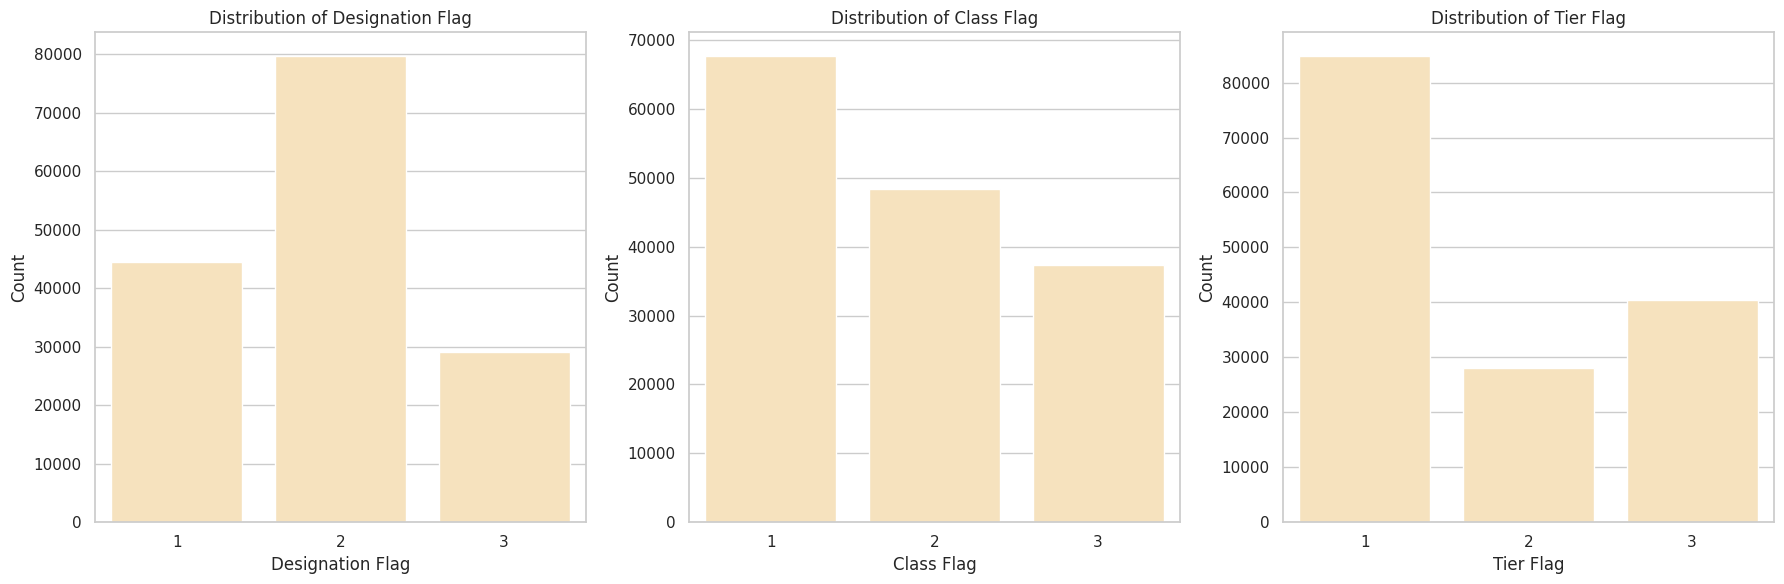

In [62]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the distribution of Designation_Flag
sns.countplot(x='Designation_Flag', data=df3, ax=axes[0],color='moccasin')
axes[0].set_title('Distribution of Designation Flag')
axes[0].set_xlabel('Designation Flag')
axes[0].set_ylabel('Count')

# Plot the distribution of Class_Flag
sns.countplot(x='Class_Flag', data=df3, ax=axes[1],color='moccasin')
axes[1].set_title('Distribution of Class Flag')
axes[1].set_xlabel('Class Flag')
axes[1].set_ylabel('Count')

# Plot the distribution of Tier_Flag
sns.countplot(x='Tier_Flag', data=df3, ax=axes[2],color='moccasin')
axes[2].set_title('Distribution of Tier Flag')
axes[2].set_xlabel('Tier Flag')
axes[2].set_ylabel('Count')

# Display the plots
plt.tight_layout()
plt.show()

- Class Flag distribution looks more balanced as compared to Designation and Tier Flag

**Q. Discuss the distribution of learners based on the Tier flag:**
1. Which companies dominate in Tier 1 and why might this be the case?
2. Are there any notable patterns or insights when comparing learners from Tier 3 across different companies?

In [63]:
# Filter for Tier 1 learners
tier_1_learners = df3[df3['Tier_Flag'] == 1]

# Count learners in Tier 1 for each company
tier_1_company_counts = tier_1_learners['company_hash'].value_counts().reset_index()
tier_1_company_counts.columns = ['company_hash', 'count']

# Top companies in Tier 1
top_tier_1_companies = tier_1_company_counts.head(10)
print(top_tier_1_companies)

                company_hash  count
0  nvnv wgzohrnvzwj otqcxwto   4642
1                    xzegojo   2947
2     zgn vuurxwvmrt vwwghzn   1804
3                  wgszxkvzn   1783
4                  vwwtznhqt   1660
5                     vbvkgz   1564
6              fxuqg rxbxnta   1513
7                     gqvwrt   1136
8                  wvustbxzx   1039
9                        zvz    983


In [64]:
# Filter for Tier 3 learners
tier_3_learners = df3[df3['Tier_Flag'] == 3]

# Count learners in Tier 3 for each company
tier_3_company_counts = tier_3_learners['company_hash'].value_counts().reset_index()
tier_3_company_counts.columns = ['company_hash', 'count']

# Top companies in Tier 3
top_tier_3_companies = tier_3_company_counts.head(10)
print(top_tier_3_companies)

                company_hash  count
0                     vbvkgz    876
1  nvnv wgzohrnvzwj otqcxwto    694
2                     gqvwrt    611
3                  bxwqgogen    592
4                    xzegojo    579
5                        zvz    416
6                  wgszxkvzn    416
7     zgn vuurxwvmrt vwwghzn    388
8                      vagmt    366
9                  wvustbxzx    336


1. Companies Dominating in Tier 1
  
  Common Factors: Companies dominating Tier 1 might have a large number of entry-level positions or companies that offer lower-than-average compensation.
  
  Possible Reasons:
  Large enterprises with many junior or mid-level positions.
  Companies in traditional industries or smaller firms with limited budgets.
2. Patterns in Tier 3 Across Different Companies

  High CTC Companies: Companies with a high number of Tier 3 learners might be in tech, finance, or other high-paying sectors.

  Career Progression: These companies might offer better career progression and compensation growth.

  Retention Strategy: Higher compensation could be a strategy to retain top talent.

**Summary Statistics**

In [65]:
designation_summary = df3.groupby('Designation_Flag')['ctc_capped'].describe()
class_summary = df3.groupby('Class_Flag')['ctc_capped'].describe()
tier_summary = df3.groupby('Tier_Flag')['ctc_capped'].describe()

In [66]:
designation_summary

,count,mean,std,min,25%,50%,75%,max
Designation_Flag,,,,,,,,
1,44536.0,8.964837e+05,7.123766e+05,2.0,400000.0,697000.0,1200000.0,11200000.0
2,79743.0,1.606745e+06,2.846606e+06,15.0,550000.0,950000.0,1700000.0,24000000.0
3,29164.0,2.508838e+06,3.605452e+06,14.0,1000000.0,1600000.0,2650000.0,24000000.0


In [67]:
class_summary

,count,mean,std,min,25%,50%,75%,max
Class_Flag,,,,,,,,
1,67733.0,9.048573e+05,6.766357e+05,2.0,450000.0,710000.0,1200000.0,20000000.0
2,48358.0,1.520279e+06,3.011210e+06,24.0,490000.0,810000.0,1500000.0,24000000.0
3,37352.0,2.848947e+06,3.778324e+06,16.0,1200000.0,1900000.0,3000000.0,24000000.0


In [68]:
tier_summary

,count,mean,std,min,25%,50%,75%,max
Tier_Flag,,,,,,,,
1,84894.0,8.710126e+05,5.787411e+05,2.0,450000.0,730000.0,1150000.0,17000000.0
2,28069.0,1.491308e+06,3.280566e+06,24.0,400000.0,730000.0,1310000.0,24000000.0
3,40480.0,3.098245e+06,3.936230e+06,16.0,1400000.0,2100000.0,3200000.0,24000000.0


- Mean CTC in all the categories and under each flag is similar
- Maximum CTC in flags 2 and 3 of all the categories is same

**Visualizing Mean Compensation**

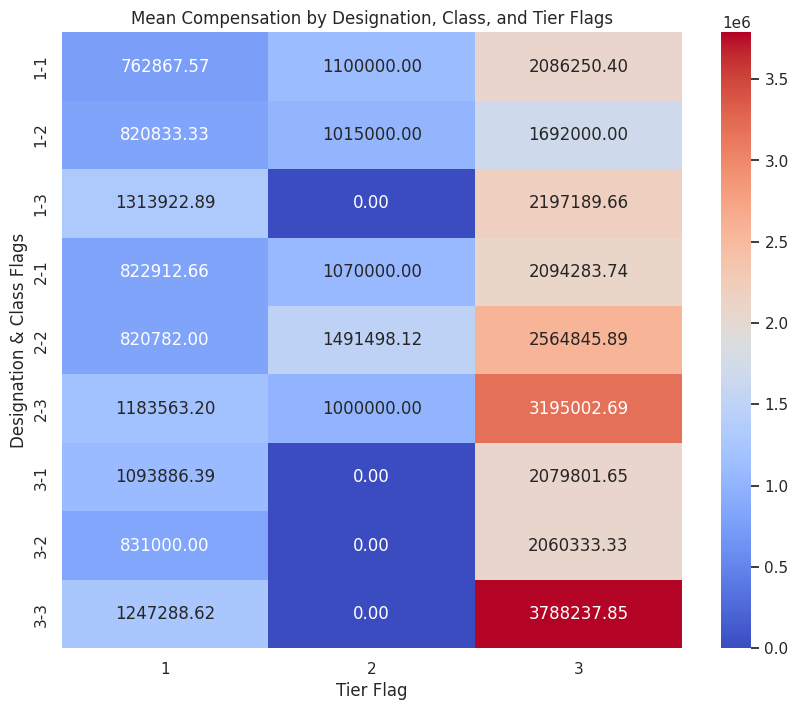

In [69]:
# Mean compensation by flags
mean_compensation_flags = df3.groupby(['Designation_Flag', 'Class_Flag', 'Tier_Flag'])['ctc_capped'].mean().unstack().fillna(0)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(mean_compensation_flags, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mean Compensation by Designation, Class, and Tier Flags')
plt.xlabel('Tier Flag')
plt.ylabel('Designation & Class Flags')
plt.show()

- Mean CTC in Designation Flag 3 , Class Flag 3 and Tier Flag 3 are highly correlated
- Followed by mean CTC of D2, C3 and T3
- Tier 2 ctc is not correlated to D3 and any of the flag of Class

**Cross-Tabulation Analysis**

Examining the relationship between these flags can reveal if there are patterns or dependencies among them.

In [70]:
designation_class_ct = pd.crosstab(df3['Designation_Flag'], df3['Class_Flag'], normalize='index')
designation_tier_ct = pd.crosstab(df3['Designation_Flag'], df3['Tier_Flag'], normalize='index')
class_tier_ct = pd.crosstab(df3['Class_Flag'], df3['Tier_Flag'], normalize='index')

print("Cross-Tabulation between Designation Flag and Class Flag:\n", designation_class_ct)
print("\nCross-Tabulation between Designation Flag and Tier Flag:\n", designation_tier_ct)
print("\nCross-Tabulation between Class Flag and Tier Flag:\n", class_tier_ct)

Cross-Tabulation between Designation Flag and Class Flag:
 Class_Flag               1         2         3
Designation_Flag                              
1                 0.911892  0.000427  0.087682
2                 0.211367  0.605947  0.182687
3                 0.352009  0.000651  0.647339

Cross-Tabulation between Designation Flag and Tier Flag:
 Tier_Flag                1         2         3
Designation_Flag                              
1                 0.916966  0.000067  0.082967
2                 0.384071  0.351956  0.263973
3                 0.460465  0.000000  0.539535

Cross-Tabulation between Class Flag and Tier Flag:
 Tier_Flag          1         2         3
Class_Flag                              
1           0.936781  0.000103  0.063115
2           0.241718  0.580235  0.178047
3           0.261137  0.000080  0.738782


Cross-Tabulation between Designation_Flag and Class_Flag:

- Designation_Flag 1: 91.2% of these employees are also in Class_Flag 1, indicating a strong overlap where lower designations coincide with lower class levels.
- Designation_Flag 2: Majority (60.6%) are in Class_Flag 2, meaning median designation levels align with median class levels.
- Designation_Flag 3: 64.7% are in Class_Flag 3, showing higher designations are often associated with higher class levels.

Cross-Tabulation between Designation_Flag and Tier_Flag:

- Designation_Flag 1: 91.7% are in Tier_Flag 1, showing low designation levels are mostly in lower tier companies.
- Designation_Flag 2: Distribution is more spread with notable percentages in all tiers.
- Designation_Flag 3: 53.9% in Tier_Flag 3, indicating higher designations are more common in higher tier companies.

Cross-Tabulation between Class_Flag and Tier_Flag:

- Class_Flag 1: 93.7% are in Tier_Flag 1, indicating lower class levels are predominantly in lower tier companies.
- Class_Flag 2: 58% in Tier_Flag 2, showing median class levels align with median tier companies.
- Class_Flag 3: 73.9% in Tier_Flag 3, indicating higher class levels are mostly in higher tier companies.

**General Insights:**

1. Alignment within Categories: There is a noticeable alignment within the categories where higher flags in one dimension (e.g., Designation_Flag) often coincide with higher flags in another dimension (e.g., Class_Flag and Tier_Flag). This suggests that performance, role importance, and company tier are interconnected.

2. Disparities at Median Levels: Employees with median flags (Flag 2) in one category tend to have a more spread distribution across other categories. This indicates that employees at the median level in terms of designation, class, or tier are not strictly confined to the median level in the other categories.

3. Low-End and High-End Correlation: Employees at the low end (Flag 1) in one category are predominantly at the low end in others, and similarly for the high end (Flag 3). This can be used to target interventions or identify opportunities for improvement for lower-tier employees.

**Recommendations:**

1. Cluster Characterization:
  - A cluster with Designation_Flag 3, Class_Flag 3, and Tier_Flag 3 would represent high-performing individuals in top companies with high compensation.


2. Targeted Recommendations:

  - Provide personalized course recommendations or career advice based on the clusters.
  -Lower-tier clusters might benefit from upskilling programs targeting higher-tier company requirements.

3. Identifying Opportunities:

  - Recognize gaps where there are inconsistencies, such as Designation_Flag 3 individuals in Tier_Flag 1 companies, and investigate the reasons.

4. Company and Job Position Profiling:

  - Profile companies and job positions based on the prevalence of higher flags.
  - Use these profiles to guide learners towards roles and companies that align with their career aspirations and skills.

5. Retention Strategies:

  - For clusters with high Designation_Flag, Class_Flag, and Tier_Flag, develop retention strategies to maintain engagement and satisfaction.

#Exploratory Data Analysis

- UniVariate Analysis
- BiVariate Analysis
- Statistical Summary

**Categorical Feature Distribution**

In [71]:
obj_cols= ['company_hash', 'job_position','orgyear']

In [72]:
num_cols= ['ctc_capped','YOE_capped']

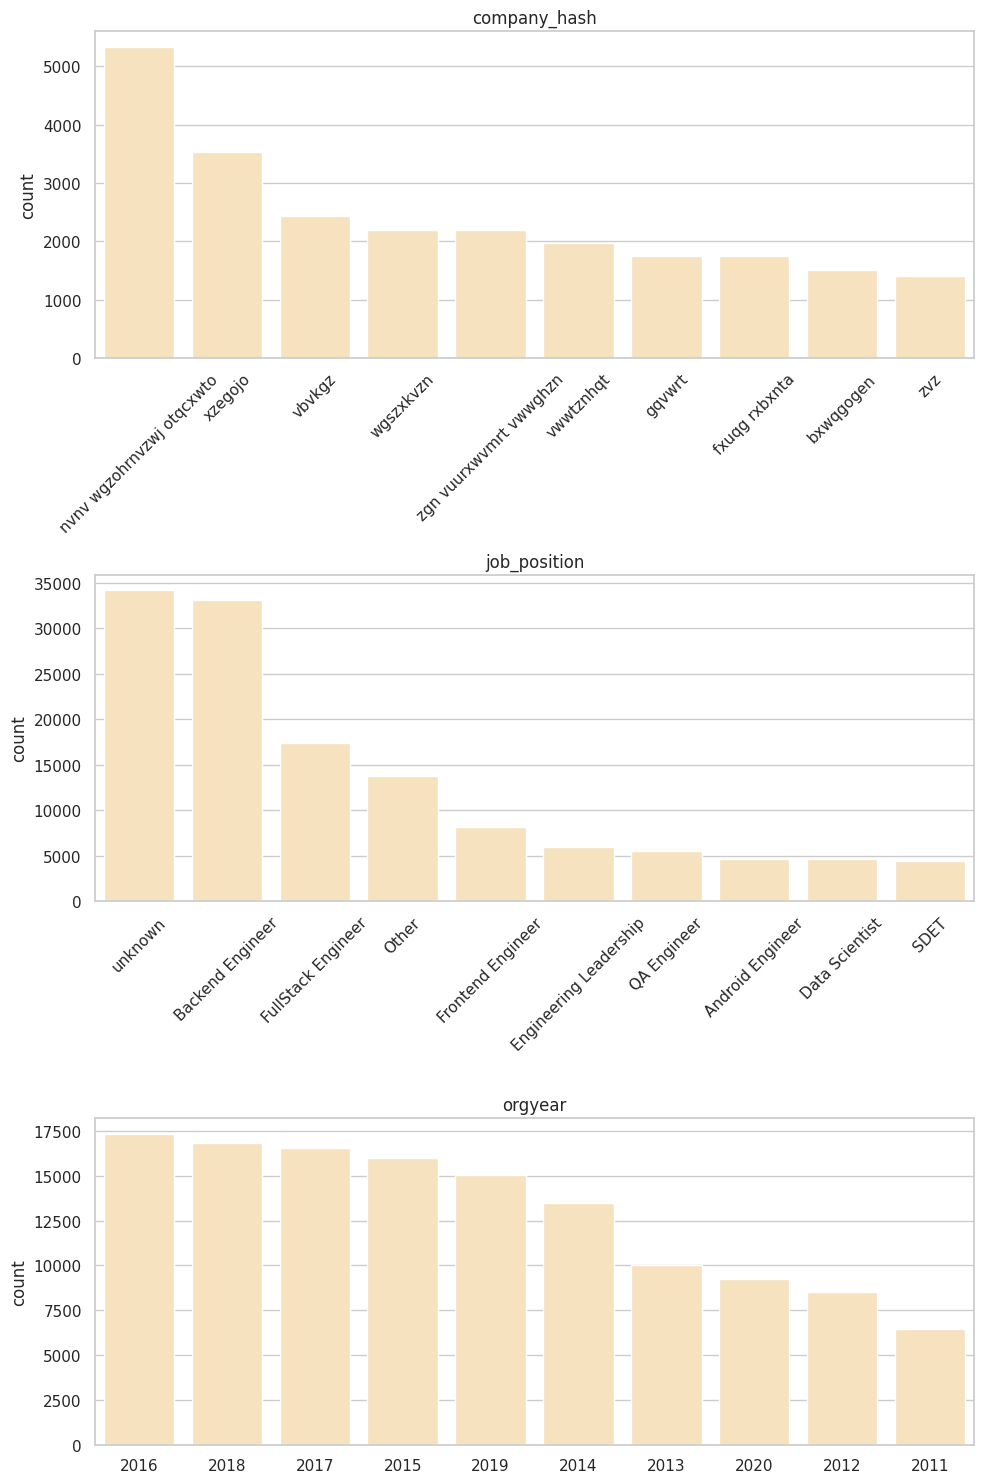

In [73]:
plt.figure(figsize=(10, 15))

i = 1
for col in obj_cols:
    # Get the top 10 values for the column
    top_10 = df3[col].value_counts().nlargest(10)
    top_10_index = top_10.index

    ax = plt.subplot(3, 1, i)
    sns.countplot(x=df3[col], order=top_10_index, color='moccasin')
    plt.title(f'{col}')
    if i <= 2:
        plt.xticks(rotation=45)

    ax.set_xlabel('')
    i += 1

plt.tight_layout()
plt.show()

Highlights:
- We can easily find top 10 companies in terms of count in the dataset
- Top job position is 'unknown' followed by 'Backend Engineer' and 'FullStack Engineer'
- Most of the employees started working in the year 2016 followed by 2018 and 2017

**Numerical Feature Distribution**

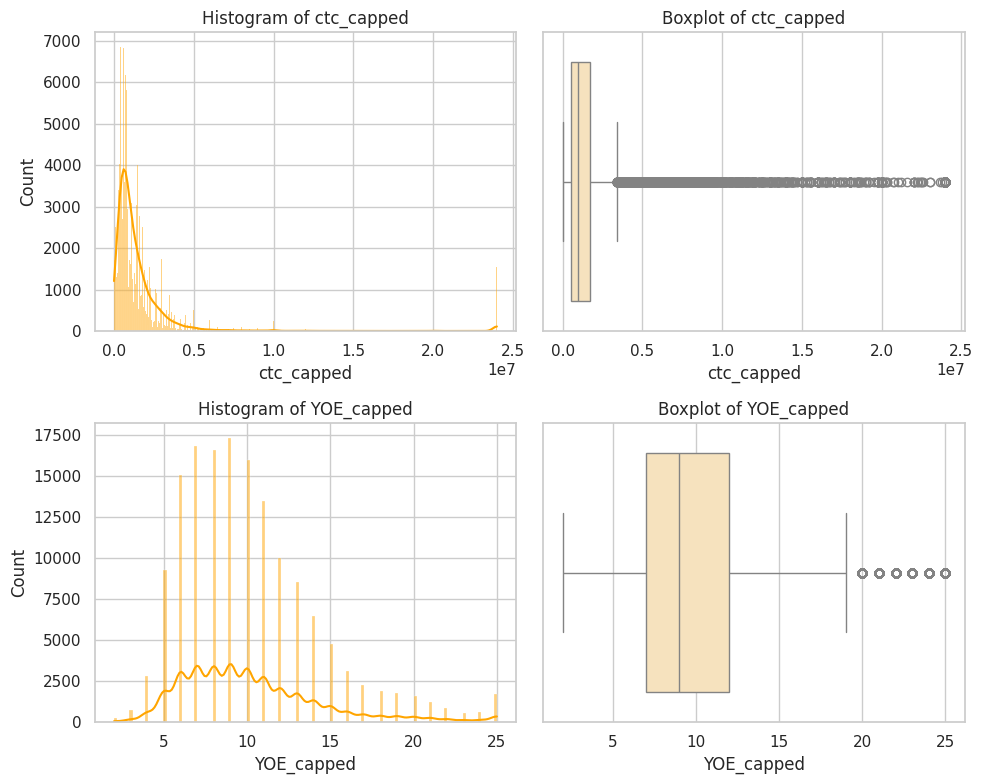

In [74]:
plt.figure(figsize=(10, 8))

# Loop through each numerical column and plot histogram and boxplot
for i, col in enumerate(num_cols):
    # Histogram
    ax1 = plt.subplot(2, 2, 2*i + 1)
    sns.histplot(df3[col], kde=True, color='orange')
    plt.title(f'Histogram of {col}')

    # Boxplot
    ax2 = plt.subplot(2, 2, 2*i + 2)
    sns.boxplot(x=df3[col], color='moccasin')
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

- Distribution of CTC is right skewed
- Most of the ctc is around 10 Lac
- Distribution of YOE is almost normal with most of the YOE lying around 6-9 years

**CTC vs Years of Experience**

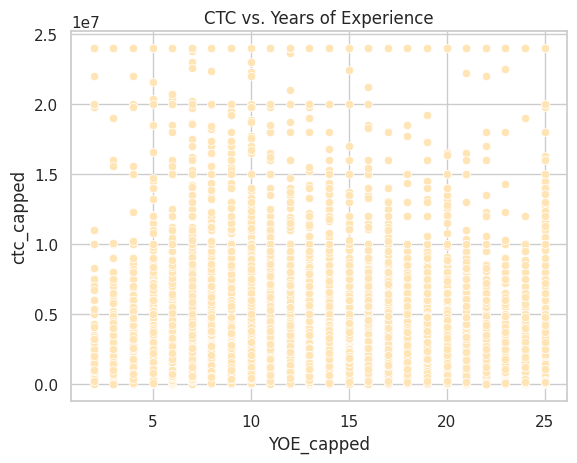

In [75]:
sns.scatterplot(x='YOE_capped', y='ctc_capped', data=df3, color='moccasin')
plt.title('CTC vs. Years of Experience')
plt.show()

There is no linear relationship or any specific pattern between Years of Experience and CTC

**Years of Experience vs Avg. CTC**

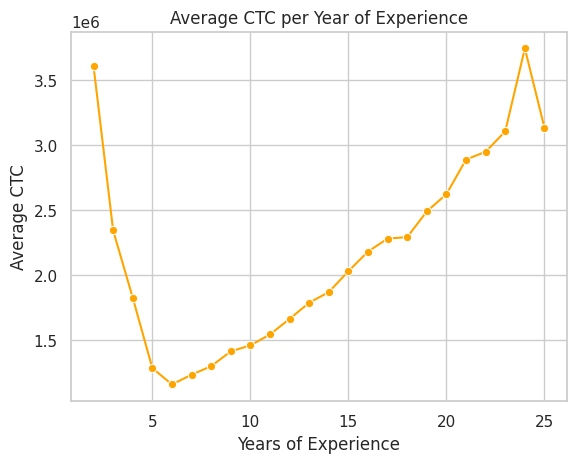

In [76]:
# Calculate average CTC per year of experience
avg_ctc_per_yoe = df3.groupby('YOE_capped')['ctc_capped'].mean().reset_index()

# Line plot with markers
sns.lineplot(x='YOE_capped', y='ctc_capped', data=avg_ctc_per_yoe, marker='o', color='orange')
plt.title('Average CTC per Year of Experience')
plt.xlabel('Years of Experience')
plt.ylabel('Average CTC')

plt.show()

- Avg. CTC is decreasing from 1 to 5 years of Experience. There might be a slight decrease in CTC with increasing experience, possibly due to industry-specific factors or career shifts.
- From 5 to 23 years it is showing natural increase in CTC, then again a drop from 23 to 24 years

**Q. Name job position that is commonly considered entry-level but has a few learners with unusually high CTCs in the dataset.**

In [77]:
# Identify common entry-level job positions (this is a subjective list, you can adjust based on your domain knowledge)
entry_level_positions = ['Junior Engineer', 'Intern', 'Trainee', 'Associate', 'Entry Level Engineer']

# Filter the dataframe for these positions
entry_level_df = df3[df3['job_position'].isin(entry_level_positions)]

# Group by job position and calculate statistics
grouped_positions = entry_level_df.groupby('job_position')['ctc_capped'].agg(['mean', 'max']).reset_index()

# Calculate the threshold to identify unusually high CTCs (e.g., 2 times the mean)
grouped_positions['high_ctc_threshold'] = grouped_positions['mean'] * 2

# Find job positions where the max CTC is greater than the high CTC threshold
unusually_high_ctcs = grouped_positions[grouped_positions['max'] > grouped_positions['high_ctc_threshold']]

# Output the results
print(unusually_high_ctcs)

  job_position      mean      max  high_ctc_threshold
0    Associate  646000.0  1500000           1292000.0


Associate is one job position considered as entry level but maximum CTC going beyond set threshold

**Q. What is the average CTC of learners across different job positions?**

In [78]:
# Group by job position and calculate the average CTC
average_ctc_by_position = df3.groupby('job_position')['ctc_capped'].mean().reset_index()

# Rename the columns for clarity
average_ctc_by_position.columns = ['job_position', 'average_ctc']

# Sort the result by average CTC in descending order
average_ctc_by_position = average_ctc_by_position.sort_values(by='average_ctc', ascending=False)

# Print the result
print(average_ctc_by_position)

                                          job_position  average_ctc
382                                          Seleceman   24000000.0
101                                       Business Man   24000000.0
425                             Senior System Engineer   24000000.0
143                                         Data entry   24000000.0
342                                           Reseller   24000000.0
..                                                 ...          ...
526  Some data entry operator like some copy's writ...      10000.0
223                                  Junior consultant      10000.0
641                                   project engineer       7900.0
189                           Full-stack web developer       7500.0
273                                       New graduate       2000.0

[652 rows x 2 columns]


**Q.For a given company, how does the average CTC of a Data Scientist compare**
**with other roles?**

In [79]:
# Filter the dataframe for rows where job_position is 'Data Scientist'
data_scientist_df = df3[df3['job_position'] == 'Data Scientist']

# Get the unique companies that have the job position 'Data Scientist'
companies_with_data_scientist = data_scientist_df['company_hash'].unique()

# Print the result
print("Companies with 'Data Scientist' job position:")
print(companies_with_data_scientist)

Companies with 'Data Scientist' job position:
['ihvznuyx' 'tqxwoogz' 'vrsgzgd ucn rna' ... 'ohbjvs xzoxsyno rrw'
 'yjhzavx bgmxo' 'wgbuzgcv wgznqvwn']


In [80]:
company_hash_given = 'xznhxn'  # Replace with the actual company_hash

# Filter the dataframe for the given company
df_company = df3[df3['company_hash'] == company_hash_given]

# Calculate the average CTC for Data Scientist role
data_scientist_ctc = df_company[df_company['job_position'] == 'Data Scientist']['ctc_capped'].mean()

# Calculate the average CTC for all other roles
other_roles_ctc = df_company[df_company['job_position'] != 'Data Scientist']['ctc_capped'].mean()

# Print the result
print(f"Average CTC for Data Scientist in company {company_hash_given}: {data_scientist_ctc}")
print(f"Average CTC for all other roles in company {company_hash_given}: {other_roles_ctc}")

# Compare the two values
if not pd.isna(data_scientist_ctc) and not pd.isna(other_roles_ctc):
    if data_scientist_ctc > other_roles_ctc:
        print("Data Scientists have a higher average CTC compared to other roles.")
    elif data_scientist_ctc < other_roles_ctc:
        print("Data Scientists have a lower average CTC compared to other roles.")
    else:
        print("Data Scientists have the same average CTC as other roles.")
else:
    print("Data Scientist role or other roles not found in the given company.")

Average CTC for Data Scientist in company xznhxn: 4833333.333333333
Average CTC for all other roles in company xznhxn: 2816223.105527638
Data Scientists have a higher average CTC compared to other roles.


We can get same information for any given company or all the companies

**CTC by Job Position**

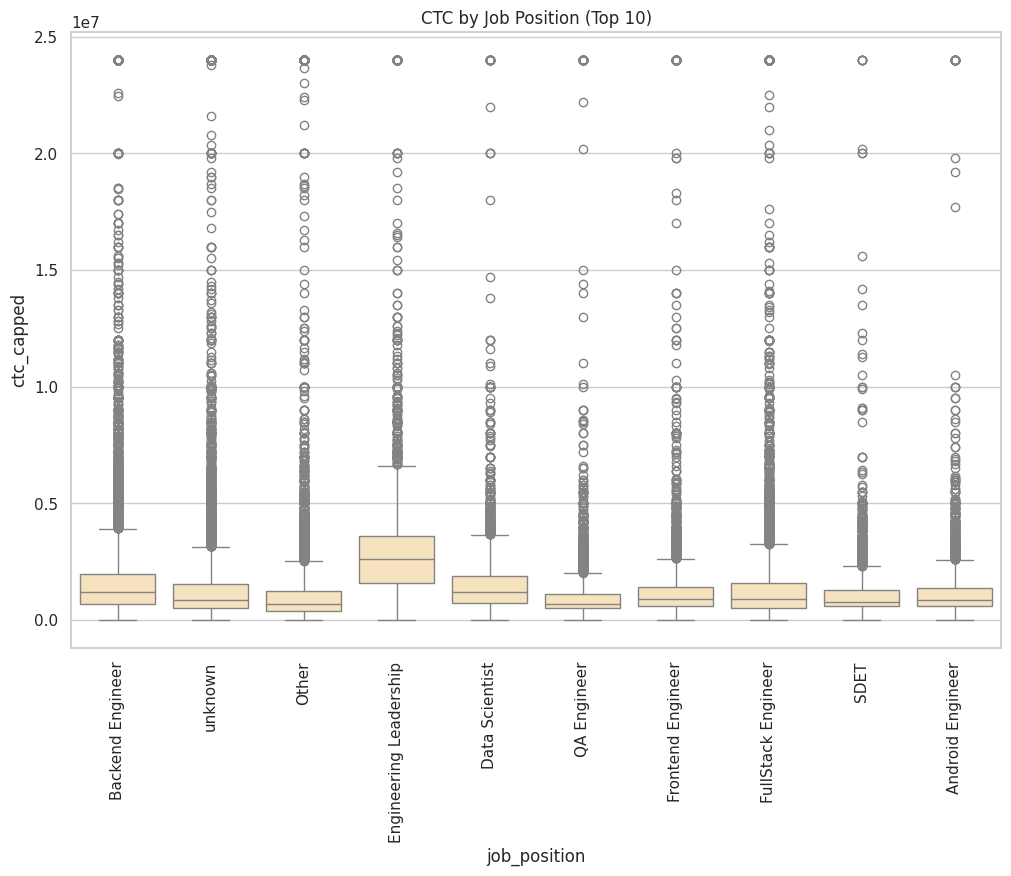

In [81]:
# Get the top 10 job positions by count
top_10_job_positions = df3['job_position'].value_counts().nlargest(10).index

# Filter the dataset to include only the top 10 job positions
df_top_10 = df3[df3['job_position'].isin(top_10_job_positions)]

# Plot the box plot for CTC by Job Position
plt.figure(figsize=(12, 8))
sns.boxplot(x='job_position', y='ctc_capped', data=df_top_10, color='moccasin')
plt.xticks(rotation=90)
plt.title('CTC by Job Position (Top 10)')
plt.show()

CTC is highest for Engineering Leadership followed by Backend Engineer and Data Scientist

**Years of Experience by Job Position**

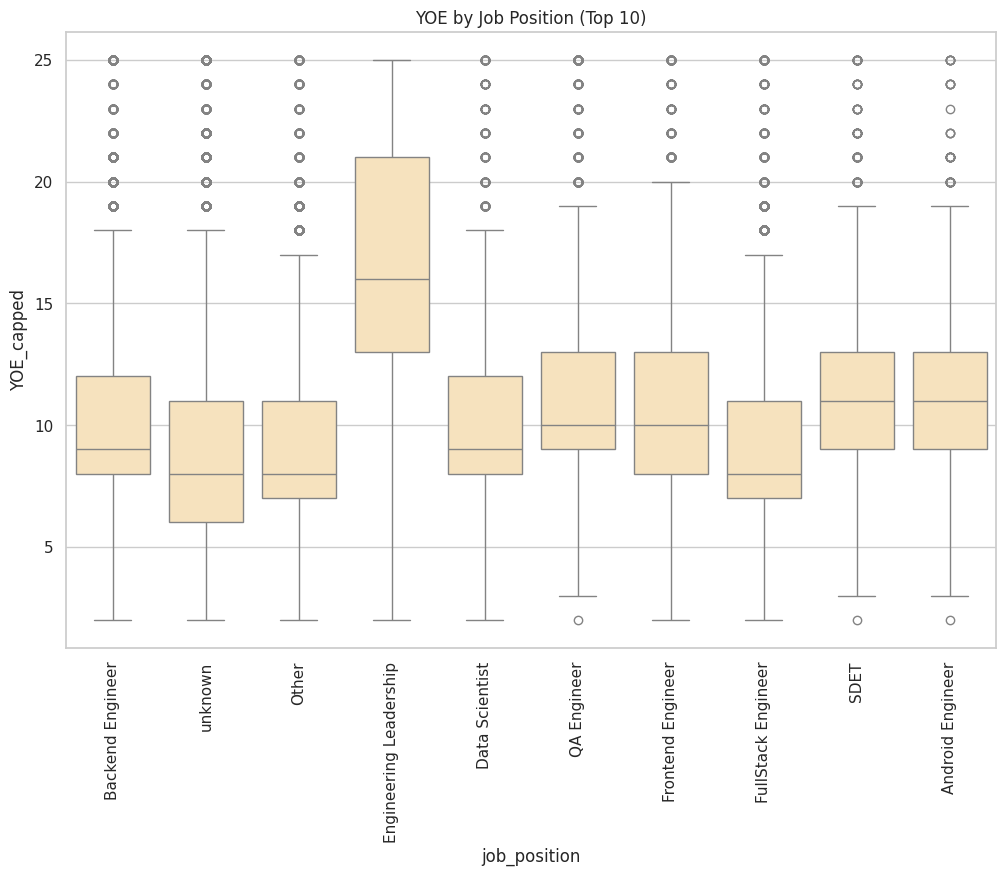

In [82]:
# Get the top 10 job positions by count
top_10_job_positions = df3['job_position'].value_counts().nlargest(10).index

# Filter the dataset to include only the top 10 job positions
df_top_10 = df3[df3['job_position'].isin(top_10_job_positions)]

# Plot the box plot for YOE by Job Position
plt.figure(figsize=(12, 8))
sns.boxplot(x='job_position', y='YOE_capped', data=df_top_10,color='moccasin')
plt.xticks(rotation=90)
plt.title('YOE by Job Position (Top 10)')
plt.show()

Years of Experience is highest for Engineering Leadership followed by Android Engineer and SDET

**Correlation Heatmap**

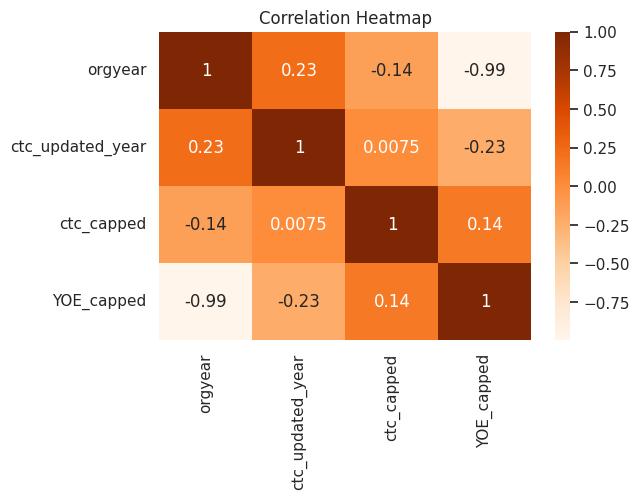

In [83]:
plt.figure(figsize=(6, 4))
sns.heatmap(df3[['orgyear', 'ctc_updated_year', 'ctc_capped', 'YOE_capped']].corr(), annot=True, cmap='Oranges')
plt.title('Correlation Heatmap')
plt.show()

- orgyear and ctc_updated_year shown weak positive correlation
- Years of Experience and orgyear show strong negative correlation
- Years of Experience and CTC show weak positive correaltion

**Statistical Summary**

In [84]:
df2.describe(include='object')

,company_hash,email_hash,job_position
count,153443,153443,153443
unique,36366,153443,652
top,nvnv wgzohrnvzwj otqcxwto,0bcfc1d05f2e8dc4147743a1313aa70a119b41b30d4a1f...,unknown
freq,5336,1,34191


In [85]:
df2.describe()

,orgyear,ctc,ctc_updated_year,YOE,ctc_capped,YOE_capped
count,153443.000000,1.534430e+05,153443.00000,153443.000000,1.534430e+05,153443.000000
mean,2014.811467,2.501398e+06,2019.42172,10.188533,1.572051e+06,10.153744
std,4.369586,1.307523e+07,1.36023,4.369586,2.670005e+06,4.212774
min,1900.000000,2.000000e+00,2015.00000,2.000000,2.000000e+00,2.000000
25%,2013.000000,5.500000e+05,2019.00000,7.000000,5.500000e+05,7.000000
50%,2016.000000,9.500000e+05,2019.00000,9.000000,9.500000e+05,9.000000
75%,2018.000000,1.700000e+06,2020.00000,12.000000,1.700000e+06,12.000000
max,2023.000000,1.000150e+09,2021.00000,125.000000,2.400000e+07,25.000000


- Dataset have got 36366 unique companies
- There are 153443 unique learners
- And 652 unique job positions
- Minimum year of Employment starting date is 1900 and maximum is 2023
- Minimum CTC is 2 and maximum 2.4 cr after capping
- Minimum Years of experience is 1 and maximum is 24 after capping

#Data Processing for Unsupervised Learning

- Encoding
- Scaling
- Feature Engineering
- Log Transformation

In [86]:
df4=df3.drop(['Designation_Flag', 'Class_Flag', 'Tier_Flag'], axis=1)

Removing these flags from the prepared data since they were meant for Manual Clustering

In [87]:
dfcopy=df.copy()

In [88]:
# Calculate frequency of email_hash in dfcopy
email_hash_freq = dfcopy['email_hash'].value_counts().reset_index()
email_hash_freq.columns = ['email_hash', 'no_of_ctc_update']

# Merge with df4 on email_hash
df4_merged = pd.merge(df4, email_hash_freq, on='email_hash', how='left')

Created a new feature 'no_of_ctc_update' signifying the number of times CTC got updated of a learner which is derived from frequency of email_hash in the dataset

In [89]:
df4_merged=df4_merged.drop(['email_hash', 'orgyear', 'ctc_updated_year'], axis=1)

Removing followng columns:
- email_hash: It is unique for each row and do not provide useful information for clustering
- orgyear: We have got Years of Experience derived from this feature which is more relevant then just the year of joining for clustering algorithm
- ctc_updated_year: We have derived a feature no. of ctc update signifying number of times ctc got updated of a learner which is more relevant to clustering algorithm than mere year as a timeline or int

In [90]:
df4_merged.head()

,company_hash,job_position,ctc_capped,YOE_capped,no_of_ctc_update
0,ngpgutaxv,Backend Engineer,700000,8,1
1,vwwtznhqt ntwyzgrgsj,Backend Engineer,400000,6,1
2,xrbhd,unknown,360000,6,1
3,wgszxkvzn,Data Analyst,440000,9,1
4,xznhxn,Backend Engineer,440000,9,1


In [91]:
df5=df4_merged.copy()

**Encoding non-numerical columns**

Frequency Encoding replaces each categorical value with its frequency in the dataset. A good compromise between simplicity and capturing categorical variable importance.

In [92]:
# Frequency encoding for company_hash
company_hash_freq = df4_merged['company_hash'].value_counts().to_dict()
df4_merged['company_hash_encoded'] = df4_merged['company_hash'].map(company_hash_freq)

# Frequency encoding for job_position
job_position_freq = df4_merged['job_position'].value_counts().to_dict()
df4_merged['job_position_encoded'] = df4_merged['job_position'].map(job_position_freq)

In [93]:
df4_merged=df4_merged.drop(['company_hash', 'job_position'], axis=1)

In [94]:
df4_merged.head()

,ctc_capped,YOE_capped,no_of_ctc_update,company_hash_encoded,job_position_encoded
0,700000,8,1,53,33154
1,400000,6,1,15,33154
2,360000,6,1,1,34191
3,440000,9,1,2199,2222
4,440000,9,1,202,33154


**Log Transformation**

Applying Log Transformation on ctc_capped column since it is right skewed. Since skewness can affect performance of clustering algorithms

In [95]:
df4_merged['ctc_capped_log'] = np.log1p(df4_merged['ctc_capped'])

In [96]:
df4_merged=df4_merged.drop(['ctc_capped'], axis=1)

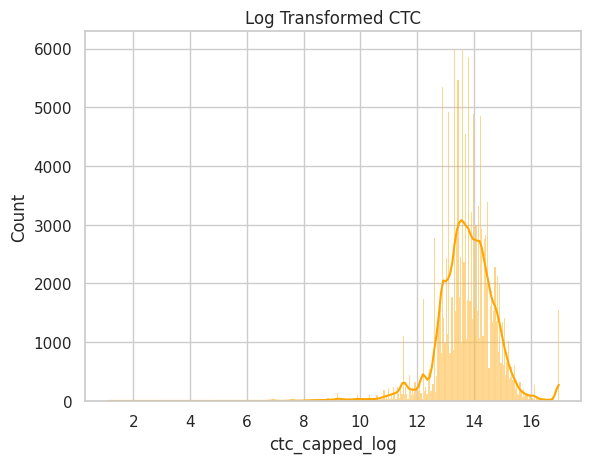

In [97]:
sns.histplot(df4_merged['ctc_capped_log'], kde=True,color='orange')
plt.title('Log Transformed CTC')
plt.show()

After applying log transformation, the feature shows normal distribution

In [98]:
df4_merged.head()

,YOE_capped,no_of_ctc_update,company_hash_encoded,job_position_encoded,ctc_capped_log
0,8,1,53,33154,13.458837
1,6,1,15,33154,12.899222
2,6,1,1,34191,12.793862
3,9,1,2199,2222,12.994532
4,9,1,202,33154,12.994532


**Standard Scaling**

In [99]:
from sklearn.preprocessing import StandardScaler

In [100]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the data
scaled_features = scaler.fit_transform(df4_merged[['YOE_capped', 'no_of_ctc_update', 'company_hash_encoded', 'job_position_encoded', 'ctc_capped_log']])

# Convert the scaled features back to a DataFrame
df_scaled = pd.DataFrame(scaled_features, columns=['YOE_capped', 'no_of_ctc_update', 'company_hash_encoded', 'job_position_encoded', 'ctc_capped_log'])

In [101]:
df_scaled.head()

,YOE_capped,no_of_ctc_update,company_hash_encoded,job_position_encoded,ctc_capped_log
0,-0.511243,-0.530558,-0.453490,1.025669,-0.271471
1,-0.985991,-0.530558,-0.485592,1.025669,-0.810550
2,-0.985991,-0.530558,-0.497419,1.103940,-0.912044
3,-0.273869,-0.530558,1.359455,-1.309018,-0.718737
4,-0.273869,-0.530558,-0.327614,1.025669,-0.718737


#Model Building

- K-means Clustering
- Hierarchical Clustering

**Checking Clustering Tendency- Hopkins Statistics**

In [102]:
from sklearn.neighbors import NearestNeighbors

In [103]:
def hopkins_statistic(X):
    X = np.array(X)  # Ensure X is a numpy array
    d = X.shape[1]  # Number of dimensions
    n = len(X)  # Number of data points
    m = int(0.1 * n)  # Subset size (10% of the data points)

    nbrs = NearestNeighbors(n_neighbors=1).fit(X)
    rand_X = np.random.random((m, d)) * np.amax(X, axis=0)
    u_distances, _ = nbrs.kneighbors(rand_X, 2, return_distance=True)

    w_distances, _ = nbrs.kneighbors(X[np.random.choice(n, m, replace=False)], 2, return_distance=True)

    u_distances = u_distances[:, 1]
    w_distances = w_distances[:, 1]

    H = (np.sum(u_distances) / (np.sum(u_distances) + np.sum(w_distances)))
    return H

hopkins_score = hopkins_statistic(df_scaled)
print(f"Hopkins Statistic: {hopkins_score}")

Hopkins Statistic: 0.9826033278324005


The value is very close to 1, which means that the dataset has a very strong clustering structure. It is likely to form well defined clusters

**Elbow Method- To select optimal number of clusters**

**Inertia**

Within Cluster Sum of Squares. This metric measures how tightly the clusters are packed. Lower inertia values indicate better-defined clusters.

In [104]:
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

In [105]:
from yellowbrick.cluster import KElbowVisualizer

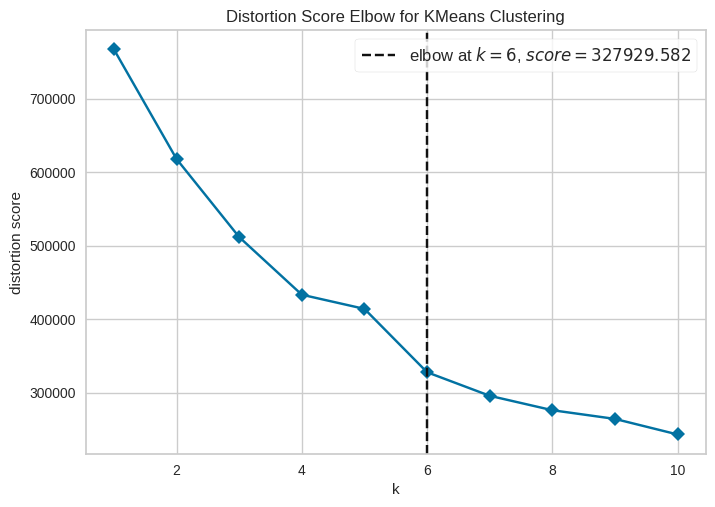

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [106]:
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(1,11), timings= False)
visualizer.fit(df_scaled)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

The elbow point suggests that 5 clusters is a good choice for our data. This is where the inertia starts to decrease at a slower rate, indicating that additional clusters beyond this point don't significantly improve the clustering quality.

**K-Means Clustering**

In [107]:
optimal_clusters = 5  # Set the optimal number of clusters as found above
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(df_scaled)

# Adding cluster labels to the DataFrame
df5['kmeans_cluster'] = kmeans.labels_

In [108]:
df5.head()

,company_hash,job_position,ctc_capped,YOE_capped,no_of_ctc_update,kmeans_cluster
0,ngpgutaxv,Backend Engineer,700000,8,1,3
1,vwwtznhqt ntwyzgrgsj,Backend Engineer,400000,6,1,3
2,xrbhd,unknown,360000,6,1,3
3,wgszxkvzn,Data Analyst,440000,9,1,0
4,xznhxn,Backend Engineer,440000,9,1,3


**Hierarchical Clustering**

In [109]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt

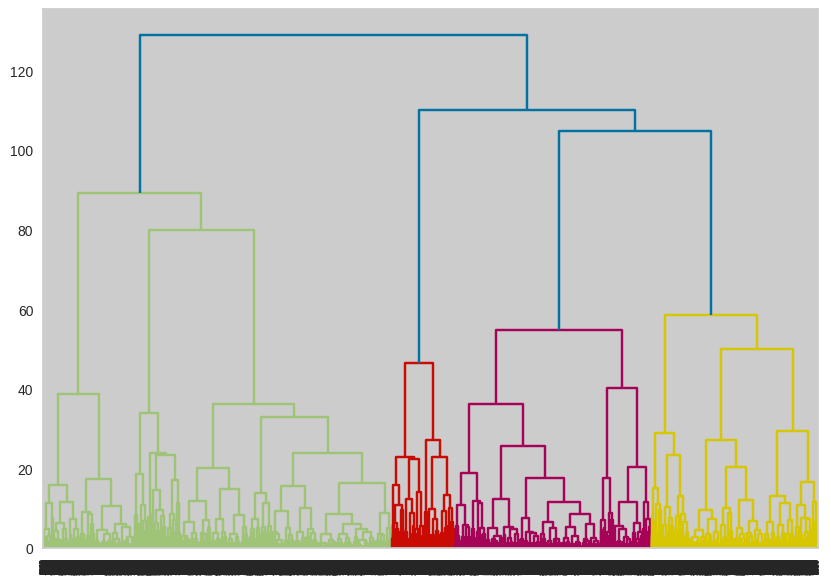

In [110]:
# Sample a subset of the data
df_sampled = df_scaled.sample(n=10000, random_state=42)

# Perform hierarchical clustering
Z = linkage(df_sampled, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.show()

- Used Representative subset of data to avoid running out of memory.
- Dendogram is showing 5 different colored branches at the end representing 5 clusters

Both Elbow Method and Dendogram are suggesting 5 clusters for the given dataset

#Evaluation of K-means Clustering

**Within-Cluster Sum of Squares (WCSS)**

The Within-Cluster Sum of Squares (WCSS) is a measure of the compactness of the clusters formed by the K-means algorithm. It represents the sum of squared distances between each data point and its corresponding cluster centroid. A lower WCSS value indicates tighter clusters, meaning that the data points within each cluster are closer to their respective centroid.

In [111]:
wcss = kmeans.inertia_
print(f'Within-Cluster Sum of Squares (WCSS): {wcss}')

Within-Cluster Sum of Squares (WCSS): 362131.63471221185


WCSS Value Consistency: The WCSS value remains consistent at 362126.90999960434 for 𝑘=5. This value represents the total within-cluster variance for the five clusters formed by K-means.

Optimal Number of Clusters:

- The elbow method helps identify the optimal number of clusters by plotting WCSS values for different 𝑘 values and looking for a point where the decrease in WCSS slows down.
- If 𝑘=5 is identified as the elbow point, it suggests that adding more clusters beyond this number does not significantly reduce the WCSS, indicating diminishing returns in terms of cluster compactness.

**Between-Cluster Sum of Squares (BCSS)**

This value represents the total squared distance between each cluster centroid and the overall mean of the data, weighted by the number of points in each cluster. A higher BCSS indicates that the cluster centroids are far from the overall mean, suggesting well-separated clusters.

In [112]:
# Assuming df_scaled is your scaled dataframe
df_scaled_copy = df_scaled.copy()

# Adding cluster labels to the DataFrame
df_scaled_copy['kmeans_cluster'] = kmeans.labels_

# Between-Cluster Sum of Squares (BCSS)
def calculate_bcss(df, kmeans):
    cluster_centers = kmeans.cluster_centers_
    overall_mean = df.drop(columns='kmeans_cluster').mean(axis=0)
    bcss = 0
    for i, center in enumerate(cluster_centers):
        size = len(df[df['kmeans_cluster'] == i])
        bcss += size * np.sum((center - overall_mean) ** 2)
    return bcss

bcss = calculate_bcss(df_scaled_copy, kmeans)
print(f'Between-Cluster Sum of Squares (BCSS): {bcss}')


Between-Cluster Sum of Squares (BCSS): 405340.05670200626


High BCSS and Low WCSS: The combination of a relatively high BCSS and a relatively low WCSS is desirable. It means that the clusters are well-separated and compact.

**Visual Inspection- PCA**

In [113]:
from sklearn.decomposition import PCA

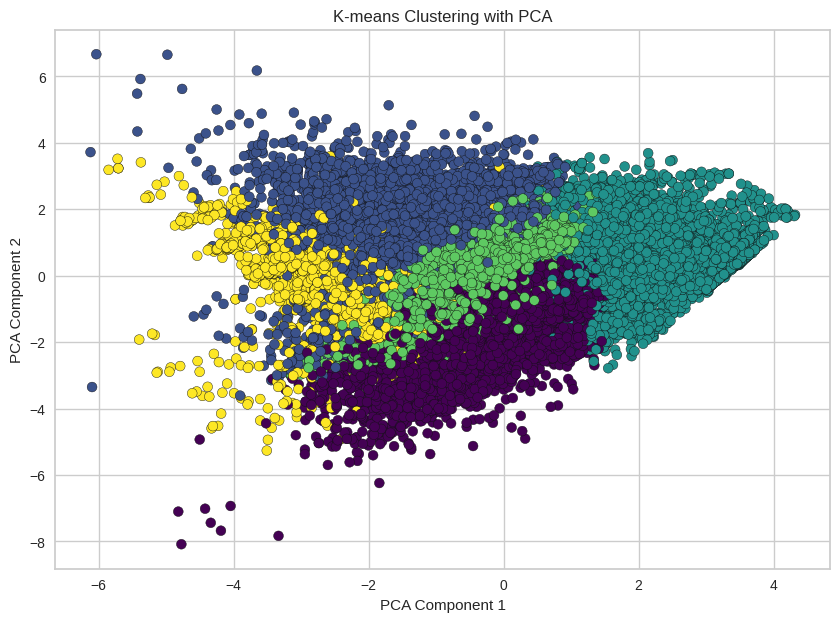

In [114]:
#Visual Inspection using PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled_copy.drop(columns='kmeans_cluster'))

df_scaled_copy['pca_one'] = pca_result[:, 0]
df_scaled_copy['pca_two'] = pca_result[:, 1]

plt.figure(figsize=(10, 7))
plt.scatter(df_scaled_copy['pca_one'], df_scaled_copy['pca_two'], c=df_scaled_copy['kmeans_cluster'], cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('K-means Clustering with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


Above we can visualize 5 clusters

#Cluster Profile and Key Characteristics

**Cluster Size and Distribution**

In [115]:
cluster_sizes = df5['kmeans_cluster'].value_counts().sort_index()
print(f'Cluster Sizes:\n{cluster_sizes}')

Cluster Sizes:
kmeans_cluster
0    51233
1    30007
2    23193
3    40150
4     8860
Name: count, dtype: int64


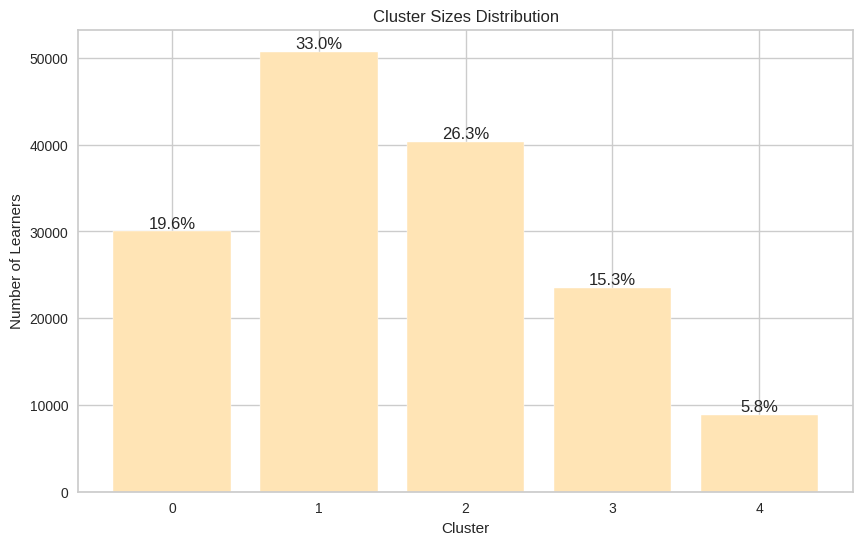

In [116]:
# Assuming cluster sizes are stored in a dictionary
cluster_sizes = {0: 30030, 1: 50706, 2: 40326, 3: 23525, 4: 8856}

# Calculate the total number of learners
total_learners = sum(cluster_sizes.values())

# Create a bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(cluster_sizes.keys(), cluster_sizes.values(), color='moccasin')

# Add percentage labels above the bars
for bar in bars:
    height = bar.get_height()
    percentage = (height / total_learners) * 100
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{percentage:.1f}%', ha='center', va='bottom')

# Add labels and title
plt.xlabel('Cluster')
plt.ylabel('Number of Learners')
plt.title('Cluster Sizes Distribution')
plt.show()

The clustering analysis resulted in 5 distinct clusters with the following sizes:
- Cluster 0: 30,030 learners (19.6%)
- Cluster 1: 50,706 learners (33.1%)
- Cluster 2: 40,326 learners (26.3%)
- Cluster 3: 23,525 learners (15.3%)
- Cluster 4: 8,856 learners (5.8%)

This distribution indicates that Cluster 1 is the largest segment, representing a significant portion of our learner base.

**CTC / Years of Exp / CTC_updates distribution across Clusters**

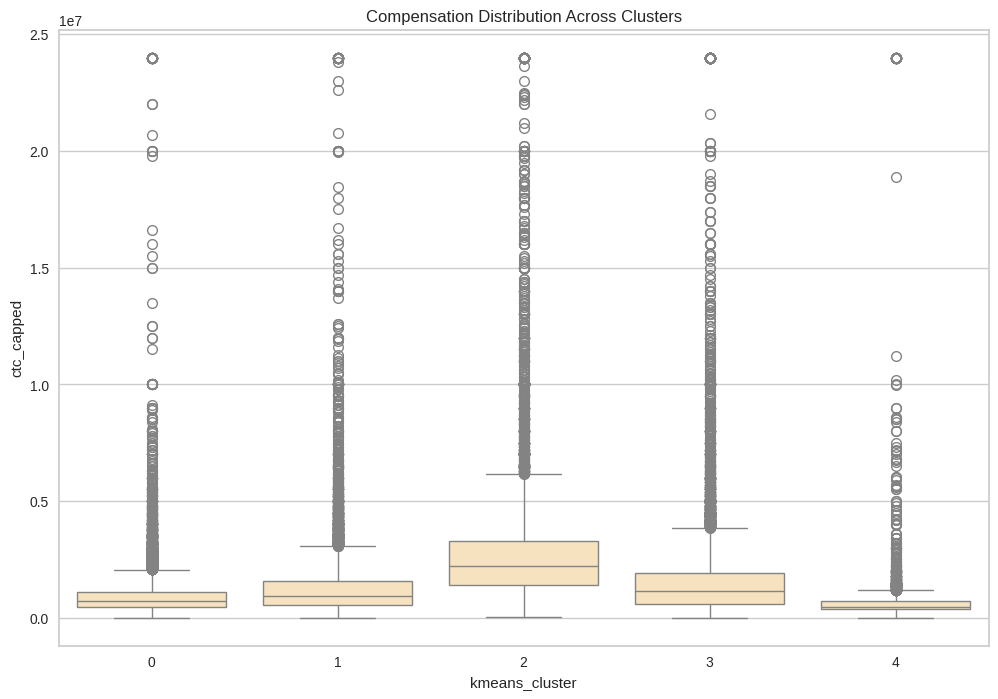

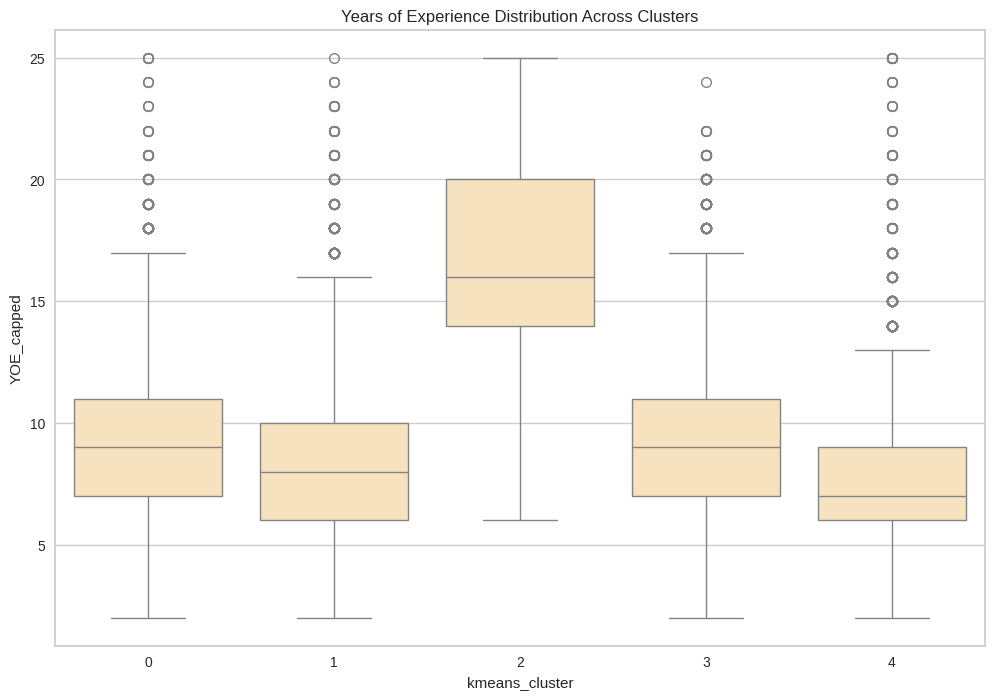

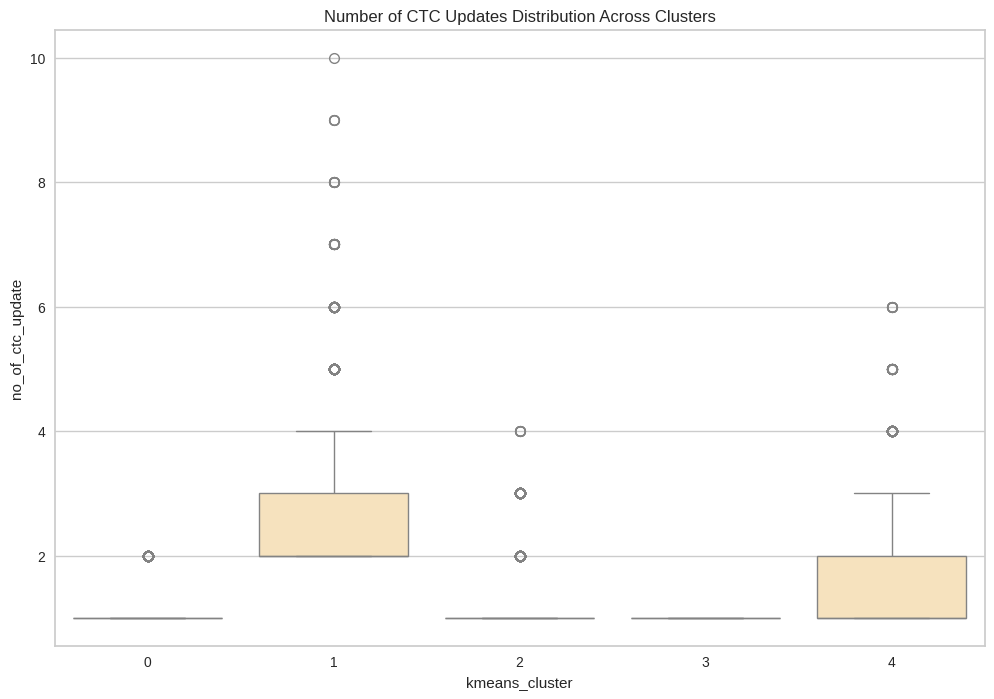

In [117]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='kmeans_cluster', y='ctc_capped', data=df5,color='moccasin')
plt.title('Compensation Distribution Across Clusters')
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(x='kmeans_cluster', y='YOE_capped', data=df5,color='moccasin')
plt.title('Years of Experience Distribution Across Clusters')
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(x='kmeans_cluster', y='no_of_ctc_update', data=df5, color='moccasin')
plt.title('Number of CTC Updates Distribution Across Clusters')
plt.show()

- Compensation is high for cluster 3 followed by cluster 2
- Years of Experience is highest for cluster 3 followed by 2 and 1
- CTC_updates is high for cluster 0 followed by 4
- Compensation and Years of Exp is relatively higher for cluster 3

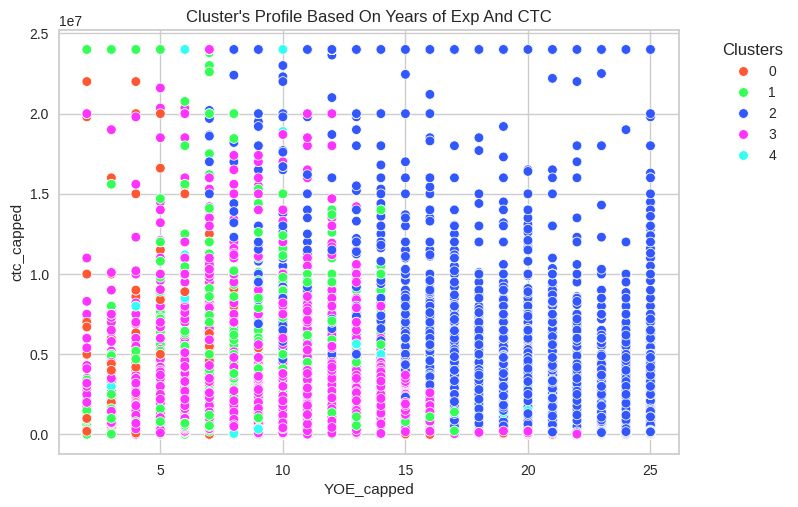

In [118]:
# Define a custom color palette with distinct colors
custom_palette = sns.color_palette(["#FF5733", "#33FF57", "#3357FF", "#FF33FF", "#33FFF3"])

# Create the scatter plot with the custom palette
pl = sns.scatterplot(data=df5, x="YOE_capped", y="ctc_capped", hue="kmeans_cluster", palette=custom_palette)

# Set the title
pl.set_title("Cluster's Profile Based On Years of Exp And CTC")

# Place the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Clusters')

# Show the plot
plt.show()

- Cluster 3 has relatively higher years of experience and compensation which was reflected from above box plots too
- Cluster 1 has lesser years of experience and w.r.t cluster 3 and most of the compensation is lower

**Cluster Profiling**

In [119]:
# Select only numeric columns for aggregation
numeric_columns = ['ctc_capped', 'YOE_capped', 'no_of_ctc_update']

# Calculate mean values for each cluster
cluster_averages = df5.groupby('kmeans_cluster')[numeric_columns].mean()

# Display the average values for each cluste
print(cluster_averages)

                  ctc_capped  YOE_capped  no_of_ctc_update
kmeans_cluster                                            
0               9.197125e+05    9.047255          1.091172
1               1.310774e+06    8.611591          2.335655
2               3.445561e+06   17.030613          1.122149
3               1.684767e+06    9.215243          1.000000
4               8.139841e+05    8.026185          1.543679


In [120]:
from collections import Counter

# Function to get the most common job positions and companies in each cluster
def get_common_entries(df, cluster_label, column_name, top_n=3):
    cluster_data = df[df['kmeans_cluster'] == cluster_label]
    most_common_entries = Counter(cluster_data[column_name]).most_common(top_n)
    return most_common_entries

# Get profiles for each cluster
cluster_profiles = {}

for cluster in range(5):
    job_positions = get_common_entries(df5, cluster, 'job_position')
    companies = get_common_entries(df5, cluster, 'company_hash')

    cluster_profiles[cluster] = {
        'average_ctc': cluster_averages.loc[cluster, 'ctc_capped'],
        'average_yoe': cluster_averages.loc[cluster, 'YOE_capped'],
        'average_ctc_updates': cluster_averages.loc[cluster, 'no_of_ctc_update'],
        'common_job_positions': job_positions,
        'common_companies': companies
    }

# Display the profiles
for cluster, profile in cluster_profiles.items():
    print(f"Cluster {cluster}:")
    print(f"  Average Compensation (CTC): {profile['average_ctc']}")
    print(f"  Average Years of Experience: {profile['average_yoe']} years")
    print(f"  Average Number of CTC Updates: {profile['average_ctc_updates']}")
    print("  Common Job Positions:")
    for job, count in profile['common_job_positions']:
        print(f"    - {job}: {count} occurrences")
    print("  Common Companies:")
    for company, count in profile['common_companies']:
        print(f"    - {company}: {count} occurrences")
    print()


Cluster 0:
  Average Compensation (CTC): 919712.4957546893
  Average Years of Experience: 9.047254699119708 years
  Average Number of CTC Updates: 1.091171705736537
  Common Job Positions:
    - FullStack Engineer: 8540 occurrences
    - Other: 8013 occurrences
    - Frontend Engineer: 5328 occurrences
  Common Companies:
    - wgszxkvzn: 862 occurrences
    - vwwtznhqt: 711 occurrences
    - zgn vuurxwvmrt vwwghzn: 701 occurrences

Cluster 1:
  Average Compensation (CTC): 1310773.8996900723
  Average Years of Experience: 8.611590628853268 years
  Average Number of CTC Updates: 2.3356550138301064
  Common Job Positions:
    - unknown: 12848 occurrences
    - Backend Engineer: 7466 occurrences
    - FullStack Engineer: 5085 occurrences
  Common Companies:
    - zgn vuurxwvmrt vwwghzn: 771 occurrences
    - wgszxkvzn: 673 occurrences
    - vwwtznhqt: 604 occurrences

Cluster 2:
  Average Compensation (CTC): 3445561.4628982884
  Average Years of Experience: 17.03061268486181 years
  Avera

Detailed Insights of Profiling are shared in next section

**Q.Do the clusters formed align or differ significantly from the manual**
**clustering efforts? If so, in what way?**

In [121]:
df8=df3.copy()

In [122]:
kmeans = KMeans(n_clusters=5)
df8['Cluster'] = kmeans.fit_predict(df8[['ctc_capped', 'YOE_capped', 'Designation_Flag', 'Class_Flag', 'Tier_Flag']])

In [123]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

In [124]:
# Create a unique identifier for each combination of manual flags
df8['Manual_Cluster'] = df8['Designation_Flag'].astype(str) + df8['Class_Flag'].astype(str) + df8['Tier_Flag'].astype(str)

# Convert the combined string to a categorical variable and then to integer codes
df8['Manual_Cluster'] = pd.Categorical(df8['Manual_Cluster']).codes

In [125]:
# Adjusted Rand Index
ari = adjusted_rand_score(df8['Manual_Cluster'], df8['Cluster'])

# Normalized Mutual Information
nmi = normalized_mutual_info_score(df8['Manual_Cluster'], df8['Cluster'])

print(f'Adjusted Rand Index: {ari}')
print(f'Normalized Mutual Information: {nmi}')

Adjusted Rand Index: 0.09607474104818903
Normalized Mutual Information: 0.12667391288122867


The values of Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI) provide insights into how similar the manual clustering is to the clusters obtained through unsupervised clustering:

Adjusted Rand Index (ARI):

  Value: 0.096
  
  Interpretation: ARI ranges from -1 to 1, where 1 indicates perfect agreement between the two clusterings, 0 indicates random agreement, and negative values indicate less than random agreement. An ARI of 0.096 suggests that there is a low level of agreement between the manual clustering and the unsupervised clustering. This means the clusters formed by the two methods are not very similar.

  Normalized Mutual Information (NMI):

  Value: 0.125

  Interpretation: NMI ranges from 0 to 1, where 1 indicates perfect agreement and 0 indicates no agreement. An NMI of 0.125 indicates a low level of shared information between the manual clustering and the unsupervised clustering. This also suggests that the clusters formed by the two methods do not align well.

Implications:

Low Similarity: Both ARI and NMI values are quite low, indicating that the clusters formed by your manual clustering (using flags) and the clusters formed by the unsupervised method (e.g., KMeans) are significantly different.

Potential Reasons: This difference could be due to various factors, such as the criteria used for manual clustering not capturing the underlying structure of the data as effectively as the unsupervised method, or the unsupervised method uncovering patterns not evident through the manual criteria.

#Insights

Cluster 0:

- This cluster consists of individuals with mid-level experience (around 7.6 years).
- They have a moderately high average compensation.
- Backend and FullStack Engineers are prominent roles apart from 'unknown'.
- Common employers include companies like zgn vuurxwvmrt, vwwghzn and wgszxkvzn.

Cluster 1:

- Individuals in this cluster have slightly more experience on average compared to Cluster 0.
- The average compensation is lower than Cluster 0.
- FullStack and Frontend Engineers are prevalent.
- The "Other" category indicates a diverse range of job positions.
- The companies overlap with those in Cluster 0, suggesting similar employer bases.

Cluster 2:

- This cluster has individuals with high compensation and above-average experience.
- Backend Engineers dominate this cluster, indicating a specialized skill set.
- There's a significant number of "unknown" job positions.
- Key employers include vbvkgz and zgn vuurxwvmrt.

Cluster 3:

- This cluster represents highly experienced professionals with significantly high compensation.
- The predominant role is in Engineering Leadership, indicating senior positions.
- The diversity in job positions (FullStack Engineer and Other) suggests a variety of responsibilities even among senior staff.
- The companies are distinct from those in other clusters, likely top-tier employers or specialized firms.

Cluster 4:

- Individuals in this cluster have lower compensation and slightly less experience compared to other clusters.
- Backend Engineers are common, but there's also a significant "Other" category.
- The most frequent employers are nvnv wgzohrnvzwj, otqcxwto and xzegojo, which are distinct from those in other clusters.



**Central Tendencies (Mean/Median) of Features**

By examining the mean and median of features within each cluster, we gain a deeper understanding of the dominant characteristics:

Cluster 0:

- Mid-level experience and moderately high compensation.
- Diverse job positions, predominantly in tech roles.

Cluster 1:

- Similar experience to Cluster 0 but with lower compensation.
- High prevalence of FullStack and Frontend Engineers.

Cluster 2:

- High compensation and specialized in Backend Engineering.
- Above-average experience, indicating skilled professionals.

Cluster 3:

- Very high compensation and extensive experience.
- Leadership roles dominate, with a focus on senior positions.

Cluster 4:

- Lower compensation and slightly less experience.
- Backend Engineers are common, with significant data inconsistencies in job positions.

**Let's Answer Few Specific Questions**

1. What percentage of users fall into the largest cluster?
  
  **Ans:** 33% of the learners fall into largest cluster 1.

2. Comment on the characteristics that differentiate the primary clusters from each other.

  **Ans:**
  
  Compensation:

  Cluster 3 has the highest average CTC, followed by Cluster 2, Cluster 0, Cluster 1, and Cluster 4.

  Experience:

  Cluster 3 members have the most experience, significantly higher than other clusters.

  Job Positions:

  Cluster 3 is dominated by leadership roles.
  
  Cluster 2 mainly comprises backend engineers.
  
  Cluster 1 has a mix of FullStack and Frontend engineers.
  
  Cluster 0 and Cluster 4 have a varied mix of job positions.

  CTC Updates:

  Cluster 0 has the highest number of CTC updates, indicating more job movement or salary revisions.
  
  Cluster 2 and Cluster 3 have fewer CTC updates, indicating stability in roles.
3. Is it always true that with an increase in years of experience, the CTC increases? Provide a case where this isn't true.

  **Ans:** No its not always true as shown in the plot earlier above. Avg. CTC is decreasing from 1 to 5 years of Experience. There might be a slight decrease in CTC with increasing experience, possibly due to industry-specific factors or career shifts.

4. Name a job position that is commonly considered entry-level but has a few
learners with unusually high CTCs in the dataset.

  **Ans:** Associate is the job position considered as entry level but maximum CTC going beyond set threshold

5. What is the average CTC of learners across different job positions?

  **Ans:**                  job_position  average_ctc

  372            Safety officer   24000000.0

  342                  Reseller   24000000.0

  288                     Owner   24000000.0

  593                     Telar   24000000.0

  ..                        ...          ...

  24              Any technical      10000.0

  257         Matlab programmer      10000.0

  641          project engineer       7900.0

  189  Full-stack web developer       7500.0

  273              New graduate       2000.0

  [652 rows x 2 columns]

6. For a given company, how does the average CTC of a Data Scientist compare with other roles?

  **Ans:**
  
  Average CTC for Data Scientist in company xznhxn: 4833333.333333333
  Average CTC for all other roles in company xznhxn: 2816223.105527638
  Data Scientists have a higher average CTC compared to other roles.

  Similarly we can find for any company or all the companies.

7. Discuss the distribution of learners based on the Tier flag:
  - Which companies dominate in Tier 1 and why might this be the case?
  - Are there any notable patterns or insights when comparing learners from Tier 3 across different companies?

  **Ans:**

  - Companies Dominating in Tier 1
  
    Common Factors: Companies dominating Tier 1 might have a large number of entry-level positions or companies that offer lower-than-average compensation.
  
    Possible Reasons:
  Large enterprises with many junior or mid-level positions.
  Companies in traditional industries or smaller firms with limited budgets.
  - Patterns in Tier 3 Across Different Companies

    High CTC Companies: Companies with a high number of Tier 3 learners might be in tech, finance, or other high-paying sectors.

    Career Progression: These companies might offer better career progression and compensation growth.

    Retention Strategy: Higher compensation could be a strategy to retain top talent.
8. After performing unsupervised clustering:
  - How many clusters have been identified using the Elbow method?
  - Do the clusters formed align or differ significantly from the manual
clustering efforts? If so, in what way?

  **Ans:** 5 clusters were identified using Elbow method. It differs w.r.t no. of clusters and tried statistical comparison as below.

  The values of Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI) provide insights into how similar the manual clustering is to the clusters obtained through unsupervised clustering:

  Adjusted Rand Index (ARI):

  Value: 0.096

  Interpretation: ARI ranges from -1 to 1, where 1 indicates perfect agreement between the two clusterings, 0 indicates random agreement, and negative values indicate less than random agreement. An ARI of 0.096 suggests that there is a low level of agreement between the manual clustering and the unsupervised clustering. This means the clusters formed by the two methods are not very similar.

  Normalized Mutual Information (NMI):

  Value: 0.125

  Interpretation: NMI ranges from 0 to 1, where 1 indicates perfect agreement and 0 indicates no agreement. An NMI of 0.125 indicates a low level of shared information between the manual clustering and the unsupervised clustering. This also suggests that the clusters formed by the two methods do not align well.

  Implications:

  Low Similarity: Both ARI and NMI values are quite low, indicating that the clusters formed by your manual clustering (using flags) and the clusters formed by the unsupervised method (e.g., KMeans) are significantly different.

  Potential Reasons: This difference could be due to various factors, such as the criteria used for manual clustering not capturing the underlying structure of the data as effectively as the unsupervised method, or the unsupervised method uncovering patterns not evident through the manual criteria.

9. From the Hierarchical Clustering results:
  - Are there any clear hierarchies or patterns formed that could suggest the different levels of seniority or roles within a company?
  - How does the dendrogram representation correlate with the 'Years of
Experience' feature?

  **Ans:**
  
  From the detailed analysis in previous section following is the summarized answer.
  
  Cluster 0:   Mid-level experience and moderately high compensation.
  Diverse job positions, predominantly in tech roles.

  Cluster 1:   Similar experience to Cluster 0 but with lower compensation.
  High prevalence of FullStack and Frontend Engineers.

  Cluster 2:   High compensation and specialized in Backend Engineering.
  Above-average experience, indicating skilled professionals.
  
  Cluster 3:   Very high compensation and extensive experience.
  Leadership roles dominate, with a focus on senior positions.

  Cluster 4:   Lower compensation and slightly less experience.
  Backend Engineers are common, with significant data inconsistencies in job positions

#Trade-Off Analysis

**Cluster 0**

Targeting Cost vs. ROI:

- Cost: Mid-level professionals might require moderate investment in upskilling and career advancement programs.

- ROI: Higher than average CTC and significant experience make them valuable. Potentially high engagement and retention due to relevant job positions.

Tailored vs. Generalized Approach:

- Tailored: Customized learning paths focusing on backend and fullstack development could lead to higher satisfaction and outcomes.

- Generalized: A broader approach might dilute the impact but could still attract professionals due to the moderately high compensation and experience levels.

**Cluster 1**

Targeting Cost vs. ROI:

- Cost: Targeting might involve moderate investment, particularly in frontend and fullstack development courses.

- ROI: Lower average compensation might mean lower direct returns, but the significant number of FullStack Engineers suggests high demand for relevant skills.

Tailored vs. Generalized Approach:

- Tailored: Programs focused on FullStack and frontend technologies could be very effective.

- Generalized: This cluster may benefit from a combination of specific and broad content due to their versatile job roles.

**Cluster 2**

Targeting Cost vs. ROI:

- Cost: Investment might be higher due to specialized backend development needs.

- ROI: High compensation indicates a potentially lucrative return on investment. Experienced professionals may value advanced and specialized courses.

Tailored vs. Generalized Approach:

- Tailored: Focusing on backend engineering and advanced development skills could yield high engagement.

- Generalized: Less effective for this cluster due to their specialized nature and higher expectations.

**Cluster 3**

Targeting Cost vs. ROI:

- Cost: High, due to the need for leadership and executive-level training programs.

* ROI: Very high, given the substantial compensation and seniority of this cluster. High potential for influencing strategic decisions within their companies.

Tailored vs. Generalized Approach:

* Tailored: Essential. Executive leadership programs and high-level technical courses would be necessary to cater to their needs.

* Generalized: Likely ineffective, as this cluster requires very specific and advanced content.

**Cluster 4**

Targeting Cost vs. ROI:

* Cost: Lower, as they might benefit from general upskilling and career advancement programs.

* ROI: Moderate, due to the lower average compensation and diverse job positions.

Tailored vs. Generalized Approach:

- Tailored: Focus on foundational and intermediate backend engineering skills could be beneficial.

- Generalized: Could be effective, as the cluster has varied job positions and lower compensation, making them receptive to broader programs.

#Recommendations

**Cluster 0:**

- Average Compensation (CTC): ₹1,313,574.27
- Average Years of Experience: 7.62 years
- Common Job Positions: Backend Engineer, FullStack Engineer
- Common Companies: zgn vuurxwvmrt vwwghzn, wgszxkvzn

Recommendations:

1. Increase Purchase Frequency:

  - Strategy: Offer advanced courses or certifications that build on existing skills. Introduce subscription-based learning models with new content released periodically to encourage ongoing participation.
  - Example: Monthly or quarterly advanced backend or fullstack engineering workshops.

2. Retention Strategies:

  - Strategy: Implement a mentorship program connecting mid-level professionals with more experienced mentors. Offer personalized career coaching sessions to help them navigate career growth.
  - Example: Bi-monthly career coaching and mentoring sessions.

3. Targeted Marketing:

  - Strategy: Focus marketing efforts on backend and fullstack engineering courses. Highlight success stories and case studies from learners in similar roles.
  - Example: Email campaigns featuring testimonials from successful backend and fullstack engineers.

**Cluster 1:**

- Average Compensation (CTC): ₹903,513.06
- Average Years of Experience: 8.02 years
- Common Job Positions: FullStack Engineer, Frontend Engineer
- Common Companies: wgszxkvzn, vwwtznhqt

Recommendations:

1. Increase Purchase Frequency:

  - Strategy: Introduce micro-credentials or nano-degrees for specific frontend and fullstack technologies. Offer bundle discounts for multiple courses.
  - Example: "Frontend Developer Toolkit" package including courses on React, Angular, and Vue.js.
2. Retention Strategies:

  - Strategy: Develop a points-based loyalty program where learners earn points for completing courses, which can be redeemed for additional courses or exclusive content.
  - Example: Points system where 100 points can be redeemed for a free advanced course.
3. Targeted Marketing:

  - Strategy: Highlight course bundles for fullstack and frontend technologies. Promote content that addresses common challenges and trends in these fields.
  - Example: Blog posts and webinars on "The Future of Frontend Development".

**Cluster 2:**

* Average Compensation (CTC): ₹1,698,640.88
* Average Years of Experience: 8.22 years
* Common Job Positions: Backend Engineer, FullStack Engineer
* Common Companies: vbvkgz, zgn vuurxwvmrt

Recommendations:

1. Increase Purchase Frequency:

  - Strategy: Offer specialization tracks in advanced backend technologies, such as microservices, cloud computing, and big data. Create exclusive content available only to frequent learners.
  - Example: "Mastering Microservices" specialization track.
2. Retention Strategies:

  - Strategy: Provide access to exclusive webinars, industry talks, and networking events. Create a premium membership tier with added benefits.
  - Example: Premium membership that includes quarterly industry webinars and access to an exclusive online community.
3. Targeted Marketing:

  - Strategy: Emphasize advanced backend engineering content in marketing materials. Showcase the career advancement of learners who have completed these tracks.
  - Example: Success stories of learners who transitioned to senior backend roles after completing advanced courses.

**Cluster 3:**

* Average Compensation (CTC): ₹3,411,238.72
* Average Years of Experience: 15.95 years
* Common Job Positions: Engineering Leadership, FullStack Engineer
* Common Companies: gqvwrt, bxwqgogen

Recommendations:

1. Increase Purchase Frequency:

  * Strategy: Introduce executive education programs and leadership workshops tailored for senior professionals. Offer continuous learning subscriptions for leadership content.
  * Example: Annual subscription to "Executive Leadership Series".
2. Retention Strategies:

  - Strategy: Implement an executive coaching program. Provide access to exclusive leadership forums and roundtable discussions with industry leaders.
  - Example: Monthly executive coaching sessions and leadership roundtables.
3. Targeted Marketing:

  - Strategy: Focus on leadership development programs and high-impact management courses. Highlight the ROI of these programs through case studies and testimonials.
  - Example: Marketing campaigns showcasing leaders who achieved significant career milestones after completing Scaler’s leadership programs.

**Cluster 4:**

- Average Compensation (CTC): ₹814,280.20
- Average Years of Experience: 7.03 years
- Common Job Positions: Backend Engineer, Other
- Common Companies: nvnv wgzohrnvzwj otqcxwto, xzegojo

Recommendations:

1. Increase Purchase Frequency:

  - Strategy: Offer foundational and intermediate courses in various backend technologies. Provide frequent learners with incentives such as discounts on advanced courses.
  - Example: Discounted rates for advanced courses upon completion of foundational courses.
2. Retention Strategies:

  - Strategy: Develop a comprehensive career pathing tool that helps learners identify and achieve their career goals. Implement a regular feedback loop to improve course offerings based on learner input.
  - Example: Personalized career pathing tool and quarterly feedback surveys with actionable improvements.

3. Targeted Marketing:

  - Strategy: Promote a wide range of backend engineering courses, emphasizing career growth and skill enhancement. Use targeted ads on platforms frequented by mid-level professionals.
  - Example: Ads on LinkedIn targeting backend engineers looking for career advancement.

**Overall Recommendations**

* Personalized Learning Paths: Implement personalized learning paths based on the cluster profiles. Utilize data to recommend courses that align with individual career goals and current industry trends.

* Exclusive Content and Membership Tiers: Develop exclusive content and membership tiers for high-value clusters, providing advanced learning opportunities and industry insights.

* Loyalty Programs and Incentives: Create loyalty programs to encourage continued learning and engagement. Offer incentives such as discounts, exclusive access, and career coaching.

* Targeted Marketing Campaigns: Design marketing campaigns that address the specific needs and preferences of each cluster. Use success stories, testimonials, and case studies to highlight the benefits of Scaler’s programs.

By implementing these recommendations, Scaler can enhance its engagement with learners, improve retention rates, and maximize the ROI of its educational programs.

#Feedback Loop for Periodic Clustering

To ensure that the clustering remains relevant and effective, it’s crucial to periodically re-run the clustering process and continuously collect and analyze data. Here are detailed recommendations:

a. Regular Re-run of Clustering Process
  1. Frequency of Re-run:

    - Quarterly Re-run: Given the fast-paced changes in the tech industry and learner behavior, it is recommended to re-run the clustering process every quarter. This allows for timely adjustments to changing trends and ensures that the clustering remains accurate.
  2. Update with New Data:

    - Incorporate Latest Data: Each re-run should include the most recent data to capture new trends, behaviors, and any shifts in the demographics of learners. This includes new enrollments, course completions, updated CTC, and job transitions.
  3. Review and Validate Clusters:

    - Validation Metrics: Use metrics like silhouette score, Davies-Bouldin index, and within-cluster sum of squares (WCSS) to validate the quality of the clusters. This ensures that the clusters are well-defined and meaningful.
    - Comparison with Previous Clusters: Compare the new clusters with previous ones to identify shifts or trends. This can help in understanding how learner profiles are evolving over time.
  4. Adapt to Business Changes:

    - Align with Business Strategy: Ensure that the clustering process aligns with Scaler’s current business strategy and objectives. If there are significant changes in course offerings or target demographics, adjust the clustering parameters accordingly.

b. Channels for Continuous Data Collection
  1. Feedback Collection Mechanisms:

    - Surveys and Questionnaires: Regularly distribute surveys to gather feedback on courses, learning experience, and future needs. Ensure surveys are short and targeted to increase response rates.
    - Post-Course Feedback: Collect feedback after each course or module to understand learner satisfaction and areas for improvement.
    - Net Promoter Score (NPS): Use NPS to gauge overall learner satisfaction and willingness to recommend Scaler to others.
  2. Behavioral Data Collection:

    - Learning Management System (LMS) Analytics: Utilize LMS data to track learner engagement, course completion rates, time spent on modules, and interaction with course materials.
    - Website and App Analytics: Use tools like Google Analytics to monitor how learners interact with the Scaler website and app. Track metrics such as page views, session duration, and navigation patterns.
  3. Preference and Interaction Tracking:

    - Course Enrollment Patterns: Analyze which courses are most popular and how learners progress through different learning paths. This can provide insights into learner preferences and trending topics.
    - Support and Interaction Logs: Monitor interactions with customer support, chatbots, and community forums to identify common issues, questions, and areas where learners seek additional help.
  4. Social Media and Community Insights:

    - Social Media Monitoring: Track mentions, comments, and reviews on social media platforms to understand public perception and gather unfiltered feedback.
    - Community Engagement: Leverage platforms like Slack, Discord, or proprietary forums where learners can discuss courses, share experiences, and provide feedback.
  5. Periodic Reviews and Workshops:

    - Focus Groups and Workshops: Conduct periodic focus groups or workshops with learners to gather in-depth insights into their experiences and expectations.
    - Advisory Panels: Establish advisory panels consisting of top learners and industry experts to provide ongoing feedback and strategic direction.

**Implementation Plan**

1. Set Up Automated Data Pipelines:

- Develop automated processes to regularly collect, process, and store feedback and behavioral data from all the mentioned channels.
2. Regular Review Meetings:

- Schedule quarterly review meetings to analyze collected data, assess the current clustering, and determine if re-clustering is necessary.
3. Action Plans Based on Insights:

- Create action plans based on the insights derived from feedback and behavioral data. Implement changes in course offerings, support mechanisms, and marketing strategies accordingly.
4. Communication with Learners:

- Keep learners informed about the steps being taken based on their feedback. This enhances transparency and builds trust in Scaler’s commitment to continuous improvement.

By following these recommendations, Scaler can maintain up-to-date and relevant clustering, leading to more effective and personalized learning experiences for its users.